A brief introduction


We will discuss machine learning algorithms for predicting financial data in this notebook. A hands-on approach is provided through the machine learning pipeline using Support Vector Machines, Random Forests, and Logistic Regression on time-series data.

It introduces you to important machine learning fundamentals in the context of finance as well as useful Python libraries so that you can start working on your own projects right away. The dataset we are using was used for the paper "Forward-looking P" (Walther et al., 2019). A binary classification problem is used to predict the return direction of the S&P 500 using this data.

Information

First look at the source

In this step, we import the packages and libraries we will use for importing and visualizing our data. NumPy provides us with matrix operations as well as numeric vectors. Using Pandas, we can use a DataFrame data type. A DataFrame enables easy data handling and is convenient to use. With MatPlotLib, we can plot graphs, while with Seaborn, we can make everything look nice.

There will not be a detailed explanation of every method we use. For more information, please refer to the official documentation.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.feature_selection import RFE, RFECV
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In this code, several Python libraries and modules are imported to perform data analysis and machine learning. Among the libraries included are numpy, pandas, matplotlib, seaborn, statsmodels.api, sklearn, and pprint.

This code imports these libraries so that their classes and functions can be used.

Using these libraries facilitates tasks such as data manipulation, visualization, statistical modeling, feature selection, preprocessing, model training, evaluation, and dimensionality reduction.

As an example, numpy provides numerical functions and array manipulation, pandas allows data manipulation and analysis through data structures known as DataFrames, matplotlib and seaborn enable visualization of data, statsmodels.api provides statistical modeling tools, and sklearn offers a variety of machine learning algorithms.

The imported modules from sklearn include various classes for feature selection (RFE and RFECV), different scalers for preprocessing data (MinMaxScaler, StandardScaler, scale), classes for dividing data into training and testing sets (train_test_split, TimeSeriesSplit), a class for hyperparameter tuning (GridSearchCV), functions for evaluating classification models (confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, roc_auc_score), and classes for different machines Algorithms for learning (SVC, LogisticRegression, RandomForestClassifier).

For dimensionality reduction, the code imports the PCA (Principal Component Analysis) module from sklearn.decomposition.

We import our data from a .csv file into a DataFrame here. Excel files and other sources can also be imported into Pandas.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/sp500_daily_train_data.csv')
# df = pd.read_csv('sp500_daily_train_data.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


You provided a code snippet that performs several tasks related to accessing and reading a CSV file from Google Drive.

Google.colab.drive is imported first by the from google.colab import drive line. Within Colab notebooks, this library provides functionality to interact with Google Drive.

After that, the drive.mount('/content/gdrive') line mounts the Google Drive to the Colab notebook. It establishes a connection between the notebook and your Google Drive, allowing you to access and read files stored there.

A specific CSV file is then read using the pd.read_csv() function from the pandas library. 'sp500_daily_train_data.csv' is the file being read. In this line of code, we assume that the CSV file is located within the mounted Google Drive folder.

We load the contents of the CSV file into a pandas DataFrame named df. DataFrames are tabular data structures provided by the pandas library. In addition to providing various functions and methods for working with the loaded data, it allows efficient manipulation and analysis of data.

After the previous line, there is a commented line, # df = pd.read_csv('sp500_daily_train_data.csv'). It suggests a method for reading the CSV file directly from the local file system, without using Google Drive. Since it is commented out, it is not executed.

You can use this code snippet to mount your Google Drive, establish a connection to it within the Colab notebook, and read a specific CSV file into a pandas DataFrame for further analysis.

Take a look at our data. Our first element is printed using the method .head() on our DataFrame.

In [ ]:
df.head()

,loctimestamp,target_ret,ret,ret_risk,r_f,svix,qskew,qkurt,market,market_risk,size,size_risk,value,value_risk,momentum,momentum_risk
0,2004-01-05,0.001599,0.012253,0.000028,0.0097,0.028482,-2.420643,23.880412,0.011929,0.000343,0.004191,0.000367,0.000100,0.000060,0.005485,0.000084
1,2004-01-06,0.002276,0.001599,0.000022,0.0092,0.025443,-2.441915,28.904873,0.001998,0.000346,0.000900,0.000366,0.001798,0.000047,0.006777,0.000128
2,2004-01-07,0.004674,0.002276,0.000044,0.0094,0.021901,-2.277177,20.941909,0.003394,0.000345,0.005385,0.000395,-0.000600,0.000027,0.004988,0.000138
3,2004-01-08,-0.008317,0.004674,0.000166,0.0099,0.023021,-2.993293,33.334794,0.004490,0.000352,0.003494,0.000358,0.006380,0.000067,0.002896,0.000135
4,2004-01-09,0.004886,-0.008317,0.000088,0.0099,0.027176,-2.103992,27.649430,-0.007226,0.000401,0.000400,0.000353,0.002098,0.000070,0.003693,0.000147


We have financial variables from January 2004 to July 2017. Our conditioning variables can be divided into three categories. Our seminar thesis provides an in-depth explanation of what these variables mean, since we are focusing on the application of machine learning to finance.

Observations: $ N = 3303 $ <br> Aspects: $ p = 14

Our features can be divided into two categories:

The first. Looking ahead:

  *  Risk-free rate
  *  $SVIX^2$  as the risk-neutral variance 
  *  Risk-neutral skewness
  *  Risk-neutral kurtosis 

The second. Backward-looking: S&P 500 return, Market return, Cost return, Value return,  Momentum return

  Variations in their 10 day rolling window

Bloomberg provides us with daily return values for the S&P 500. The other factors were taken from [Kenneth French's website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html).

Analyzing our data


It is useful to visualize and understand our dataset before we jump into machine learning techniques and their benefits.

We use dates as an index to make working with our data easier. The loctimestamp will be converted to a datetime format and set as index with .set_index() 

In [ ]:
df['loctimestamp'] = pd.to_datetime(df['loctimestamp'])
df = df.set_index('loctimestamp')
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day

A DataFrame named df is manipulated by performing several operations related to the 'loctimestamp' column and time-based analysis.

The code converts the values in the 'loctimestamp' column to datetime format first. The pandas library provides the pd.to_datetime() function for this purpose. This function ensures that the values in the 'loctimestamp' column are interpreted as timestamps or dates rather than just strings.

The code then sets the 'loctimestamp' column as the DataFrame's index. In this case, df.set_index() is used. By setting the index to the 'loctimestamp' column, the code creates a time-based order for the data, making time-based analysis more intuitive.

Afterward, the code adds three new columns to the DataFrame: 'Year', 'Month', and 'Day'. Columns are populated with the components of the index, which represents the 'loctimestamp' column after it has been set as an index. From the index, the year, month, and day components are extracted using the .index.year, .index.month, and .index.day attributes.

The code adds these new columns to the DataFrame to provide additional time-based information. 'Year' contains the year component, 'Month' contains the month component, and 'Day' contains the day component of 'loctimestamp'. Based on these temporal aspects, the data can be further analyzed and grouped.

Summary: The code snippet converts the 'loctimestamp' column into datetime format, sets it as the index of the DataFrame, and adds three new columns ('Year', 'Month', 'Day') based on the corresponding components of the 'loctimestamp' index. By grouping the data by year, month, or day, it is easier to perform time-based analysis.

To determine if our variables are linearly related, let's plot a correlation matrix. We will refer to variables as 'features' from now on, since this is the name commonly used in machine learning

(15.0, 0.0)

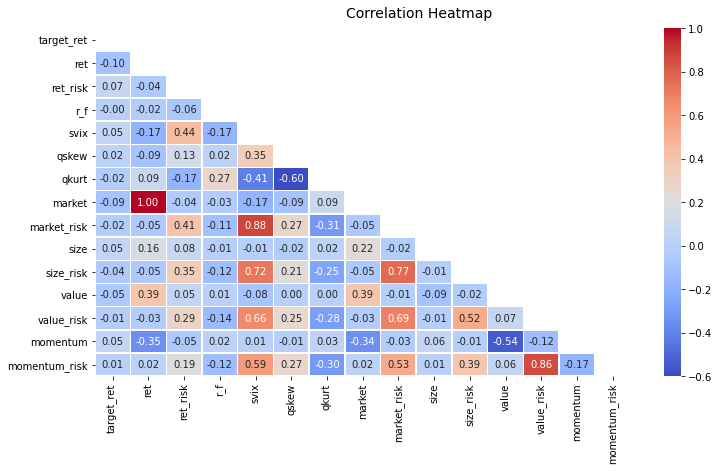

In [ ]:
"""Creating a separate DataFrame without Year, Month, Day to only look at correaltion of the features"""
dforiginal = df.drop(columns= ['Year', 'Month', 'Day'])

f, ax = plt.subplots(figsize=(12, 6))
corr = dforiginal.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=0.5, mask=mask)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)
#manual format setting
ax.set_ylim(len(corr),0)

Several tasks are performed in the provided code snippet to visualize the correlation between features in a DataFrame.

By dropping the columns 'Year', 'Month', and 'Day' from the original DataFrame df, the code creates a new DataFrame named dforiginal. The objective of this step is to isolate the original features and create a separate DataFrame that focuses only on these features, excluding the additional time-based columns.

A heatmap representing the correlation between the features in the dforiginal DataFrame is then displayed by the code. To visualize the correlation matrix, the plot is configured with a 12 by 6 aspect ratio.

The code uses the .corr() function to calculate the correlation between the features. Matrix containing pairwise correlations between all pairs of features in DataFrame, offering insight into relationships and dependencies.

Using the np.zeros_like() function, the code emphasizes only the lower triangular part of the correlation matrix. As with the correlation matrix, this mask is a boolean matrix. The code hides the upper triangular part of the correlation matrix in the heatmap plot by setting the upper triangular values of the mask to True using the np.triu_indices_from() function.

Using the seaborn library's sns.heatmap() function, the code generates a heatmap plot. We round the correlation matrix to two decimal places and annotate the heatmap with the corresponding correlation values. We apply the colormap "coolwarm", which uses cool colors (blue) for low correlation values and warm colors (red) for high correlation values.

Using f.subplots_adjust(), the code adjusts the top margin of the plot. With this adjustment, the title can be accommodated at the top of the plot.

It provides a clear description of the plot's purpose and content by setting the plot's title to "Correlation Heatmap" with a font size of 14.

Finally, the code manually sets the y-axis limits to match the correlation matrix's length. In this way, all rows of the correlation matrix are displayed correctly on the y-axis, preventing any truncation or overlap.

This code snippet visualizes the pairwise correlations between features in the dforiginal DataFrame using a correlation heatmap plot. It provides valuable insights into the relationships and dependencies among the features by isolating the original features, computing the correlation matrix, and displaying the heatmap with proper formatting and annotations.

There is a correlation between 'market' and 'ret' of 1.0 since 'market' represents the U.S. return. 'Ret' is the return of the S&P 500 index (see Kenneth French's website). As we do not expect 'market' to add any information to our models, we do not include it as a feature.

Furthermore, 'svix' is highly correlated with 'market_risk', as one would expect for an estimator of S&P 500 risk neutral density variance.

Here is how our return time-series looks. This is done by plotting daily returns and their monthly averages.

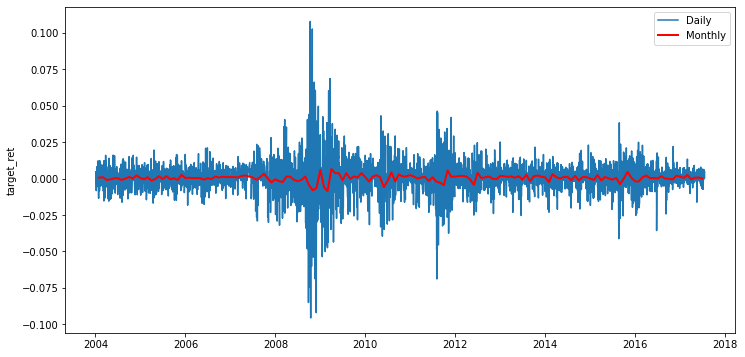

In [ ]:
Data_Monthly = df[df.columns.tolist()].resample('M').mean()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df.loc['2004-01-05':'2017-07-18', 'target_ret'], label='Daily')
ax.plot(Data_Monthly.loc['2004-01-05':'2017-07-18', 'target_ret'], linewidth=2, label='Monthly', color='red')
ax.set_ylabel('target_ret')
ax.legend();

The provided code snippet visualizes and compares daily and monthly data for the 'target_ret' column.

By resampling the original DataFrame df, the code first creates a new DataFrame named Data_Monthly. Resampling is done monthly, so the resulting DataFrame contains the average values of the columns in df for each month.

As a next step, the code sets up a plot with a figure and axes object. By doing this, the framework for visualizing the data is prepared.

Using the axes object, the code plots the 'target_ret' column from the original DataFrame df. Within a specified date range, the plotted data represents the daily values of the 'target_ret' column.

The code also plots the 'target_ret' column from the resampled DataFrame Data_Monthly as another line plot. Within the same date range, the plotted data represents the monthly averages of the 'target_ret' column. To differentiate it from the daily values, the line is drawn with a linewidth of 2.

Using the ax.set_ylabel() function, the code sets the y-axis label to 'target_ret' for clarity. Understanding the data along the y-axis is made easier by this.

Ax.legend() is used to add a legend to the plot. It displays labels for the plotted lines, distinguishing between daily and monthly data. In this way, the two lines in the plot can be identified and differentiated easily.

This code snippet generates a line plot that compares the daily values of the 'target_ret' column to its monthly averages using the original DataFrame. This code provides a visual representation of any variations or patterns in the 'target_ret' column at different temporal resolutions by resampling the data on a monthly basis. By comparing the daily and monthly data for this column, the resulting plot helps to clarify the relationship between the two.

In addition to the increased variance during the financial crisis between 2008 and 2010, the euro crisis had a significant impact on the American stock market around 2011.

In [ ]:
dforiginal.describe(include=[np.number]).loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(4).transpose()

,mean,std,min,25%,50%,75%,max
target_ret,0.0003,0.0117,-0.0957,-0.0039,0.0007,0.0053,0.1079
ret,0.0002,0.0116,-0.0957,-0.0041,0.0006,0.0052,0.1027
ret_risk,0.0002,0.0006,0.0000,0.0000,0.0001,0.0002,0.0211
r_f,0.0127,0.0174,0.0004,0.0012,0.0020,0.0201,0.0541
svix,0.0394,0.0494,0.0088,0.0167,0.0238,0.0414,0.5721
qskew,-2.4602,0.9379,-10.3639,-2.9264,-2.4104,-1.9403,6.5674
qkurt,24.3657,16.6244,0.4507,13.1611,20.8519,30.2706,214.2776
market,0.0002,0.0118,-0.0938,-0.0044,0.0007,0.0054,0.0932
market_risk,0.0014,0.0031,0.0000,0.0003,0.0006,0.0012,0.0342
size,0.0000,0.0057,-0.0382,-0.0034,0.0001,0.0034,0.0376


This code snippet generates and formats summary statistics for the numerical columns in a DataFrame called dforiginal.

To generate summary statistics, the code uses the .describe() method on the DataFrame dforiginal. The code ensures that only numerical columns are included in the summary statistics by providing the argument include=[np.number].

From the generated summary statistics, the code selects specific descriptive statistics. Statistics are presented in terms of mean, standard deviation, minimum value, 25th percentile (first quartile), median (50th percentile), 75th percentile (third quartile), and maximum value. Statistics provide insight into the numerical variables' distribution, spread, and central tendency.

Using the .round(4) method, the code rounds the selected descriptive statistics to four decimal places to improve readability and presentation. As a result, the statistics are presented concisely and consistently.

The code then transposes the resulting summary statistics DataFrame using .transpose(). As a result of this operation, the statistics are the rows and the variables (numerical columns) are the columns of the DataFrame. By transposing the DataFrame, it is easier to understand each numerical variable's statistics.

This code snippet generates and formats a summary statistics DataFrame for the numerical columns in the dforiginal DataFrame. The code provides a comprehensive analysis of key statistical measures for the numerical variables by utilizing the .describe() method, selecting specific descriptive statistics, rounding the values, and transposing the DataFrame. It provides a clear and organized view of the distribution and characteristics of the numerical data.

The preprocessing process



For this project, we got prepared data, which is not always the case. The majority of the time, you have to search for the data yourself and transform it into something meaningful. As part of this process, we look for format issues, outliers, trends, and missing or incorrect data. This task can have a significant impact on the success of your project if you underestimate its importance.

Engineering features


Feature engineering involves extracting valuable information from your data to get the most appropriate features based on the data, the model, and the task. Zheng et al. (2018) demonstrate how this can significantly improve your estimator's performance.

The first step is to insert the column containing the direction of the return on day 't+1'. $1,-1$ corresponds to positive and negative returns. Later, we will try to predict this column. Several libraries for Logistic Regression require $0,1$ labeling, which we also provide.

In [ ]:
df.loc[df.target_ret >= 0, 'ret_dir'] = 1
df.loc[df.target_ret < 0, 'ret_dir'] = -1

df.loc[df.target_ret >= 0, 'ret_dir_logit'] = 1
df.loc[df.target_ret < 0, 'ret_dir_logit'] = 0

Using the values from another column, 'target_ret', the provided code snippet assigns specific values to two columns, 'ret_dir' and 'ret_dir_logit', in a DataFrame named df.

In the DataFrame df, the code assigns a value of 1 to the 'ret_dir' column for rows where the corresponding value in the 'target_ret' column is greater than or equal to 0. For positive or non-negative values of 'target_ret', this assignment sets the 'ret_dir' column to 1.

As a next step, the code assigns a value of -1 to the 'ret_dir' column in the DataFrame df when the corresponding value in the 'target_ret' column is less than zero. For negative values of 'target_ret', this assignment sets the 'ret_dir' column to -1.

Similarly, the code assigns values to the 'ret_dir_logit' column in the DataFrame. For rows where the corresponding value in the 'target_ret' column is greater than or equal to 0, it assigns 1 to the 'ret_dir_logit' column. For positive or non-negative values of 'target_ret', this assignment sets the 'ret_dir_logit' column to 1.

A value of 0 is assigned to the 'ret_dir_logit' column in the DataFrame df for rows where the corresponding value in the 'target_ret' column is less than 0. 'ret_dir_logit' is set to 0 for negative values of 'target_ret'.

This code snippet assigns the values of the 'target_ret' column to two columns in the DataFrame df, 'ret_dir' and 'ret_dir_logit'. For non-negative values of 'target_ret', the 'ret_dir' column is set to 1; for negative values, it is set to -1. For non-negative values of 'target_ret', the 'ret_dir_logit' column is assigned 1 and for negative values, 0 is assigned. With the help of these assignments, the 'target_ret' values can be categorized or classified based on their directional nature, allowing for further analysis or modeling.

Past returns may contain some information. The last five days' returns are added as features. In addition to today's return 'ret', this feature is also available.

In [ ]:
df['ret-1'] = df['ret'].shift(1)
df['ret-2'] = df['ret'].shift(2)
df['ret-3'] = df['ret'].shift(3)
df['ret-4'] = df['ret'].shift(4)
df['ret-5'] = df['ret'].shift(5)

Using the provided code snippet, several new columns are created in a DataFrame named df by shifting the values of the existing column 'ret'.

In the first step, a new column named 'ret-1' is added to the DataFrame df. By shifting the values of the 'ret' column backwards, this column is created. The 'ret-1' column corresponds to the previous row's 'ret' value.

The code then creates a new column named 'ret-2' in the DataFrame. The values of the 'ret' column are shifted two positions backward to produce this column. The 'ret-2' column represents the 'ret' value from two rows ago.

In the same way, the code continues to create new columns. A 'ret-3' column is added by shifting the values of 'ret' three positions backward, a 'ret-4' column by shifting the values four positions backward, and a 'ret-5' column by shifting the values five positions backward.

DataFrame df includes the original 'ret' column as well as newly created 'ret-1', 'ret-2', 'ret-3', 'ret-4', and 'ret-5' columns. From one to five rows ago, these additional columns represent the historical values of 'ret'.

By shifting the values of the 'ret' column backwards, this code snippet adds several new columns to the DataFrame df. The new columns represent the 'ret' values from a specific number of rows ago, ranging from one row ago ('ret-1') to five rows ago ('ret-5'). Shifting or lagging column values can be useful for time series analysis or for incorporating historical information into features.

The rolling window means for the last five and ten days are calculated next. Exponentially weighted moving averages are also included. With a halflife of 5, 10, and 30 days, the observation's weights in this special moving average decrease exponentially. Trends and momentum are detected using these indicators.


In [ ]:
df['ret_mean_5'] = df['ret'].rolling(window=5).mean()
df['ret_mean_10'] = df['ret'].rolling(window=10).mean()

In the provided code snippet, rolling means are calculated for the 'ret' column in a DataFrame named df.

To begin with, the code adds a new column to the DataFrame df called 'ret_mean_5'. The rolling mean of the 'ret' column is calculated using a 5 window size for this column. Using the rolling mean, data is smoothed by calculating the average value of the 'ret' column for each row and the four preceding rows. Over this 5-row window, the 'ret_mean_5' column captures the average trend of the 'ret' values.

In the DataFrame df, a new column named 'ret_mean_10' is added. With a window size of 10, the rolling mean of the 'ret' column is calculated. In the same way as the 'ret_mean_5' column, the 'ret_mean_10' column represents the average value of the 'ret' column for each row and the nine rows preceding it. With a window size of 10, the rolling mean provides a smoother representation of the 'ret' values.

Using different window sizes, this code snippet calculates rolling means for the 'ret' column in the DataFrame df. The .rolling().mean() method creates two new columns, 'ret_mean_5' and 'ret_mean_10', which represent the average values of 'ret' over various window sizes. Rolling mean columns smooth out fluctuations in the 'ret' data and capture the overall trend or central tendency. This enables insights into longer-term patterns and trends by aggregating and smoothing data.

In [ ]:
df['ret_ewma_5'] = df['ret'].ewm(halflife = 5).mean()
df['ret_ewma_10'] = df['ret'].ewm(halflife = 10).mean()
df['ret_ewma_30'] = df['ret'].ewm(halflife = 30).mean()

A DataFrame named df is used to calculate exponentially weighted moving averages (EWMA) for the 'ret' column.

First, the code adds a column named 'ret_ewma_5' to the DataFrame. The EWMA of the 'ret' column with a halflife of 5 is computed to create this column. By giving more weight to recent values and gradually decreasing the weight for older values, the EWMA calculates the average value of the 'ret' column. The 'ret_ewma_5' column represents the smoothed average of 'ret' with a shorter memory span, capturing recent trends and changes.

In the DataFrame df, another new column is added named 'ret_ewma_10'. Calculate the EWMA of the 'ret' column with a halflife of 10 to obtain this column. As with the 'ret_ewma_5' column, the 'ret_ewma_10' column represents the exponentially weighted average of the 'ret' values. Because of its longer halflife, it has a slightly longer memory. Using this column, you can get a smoother average that still responds to recent changes, but retains some influence from older values as well.

A third column is also created in the DataFrame df called 'ret_ewma_30'. Calculated from the EWMA of the 'ret' column with a halflife of 30. This column represents the exponentially weighted moving average of the 'ret' values over a longer period of time. The longer halflife of this column results in a smoother average, capturing longer-term trends while responding less to short-term fluctuations.

This code snippet calculates exponentially weighted moving averages (EWMA) for the 'ret' column in the DataFrame df. Using the .ewm().mean() method, it creates three new columns, 'ret_ewma_5', 'ret_ewma_10', and 'ret_ewma_30', representing smoothed averages of 'ret' over time. By using these columns, we can capture trends, smooth out noise, and identify longer-term patterns in the 'ret' data. Different halflife values allow for customizing the memory span and responsiveness to recent changes, which allows for a more nuanced analysis of the underlying data.

The first 9 rows contain NaNs introduced by our rolling mean features, so they cannot be used for training. All data is preserved in an additional DataFrame.

In [ ]:
df_org = df
df = df[9:]

In the provided code snippet, operations are performed on a DataFrame named df.

This code creates a new DataFrame called df_org and assigns it the same data as the original DataFrame df. In this step, the original DataFrame is preserved in its entirety and can be referenced separately from any subsequent modifications.

The code then assigns a subset of its own data to the DataFrame df. This update includes all rows starting from index 9 and onward, effectively excluding the first 9 rows of the DataFrame. Overwriting df with this subset effectively discards or removes the initial data.

Summary: This code snippet creates a new DataFrame named df_org that holds the same data as the original DataFrame df, preserving the original dataset. Then, it reassigns df a subset of its own data, excluding the first nine rows. With this operation, we can work with a modified DataFrame that starts from a later point in the data, potentially useful for focusing on a specific time period or analyzing the data without considering the initial observations.

Let's review all our features, including the engineered ones

(27.0, 0.0)

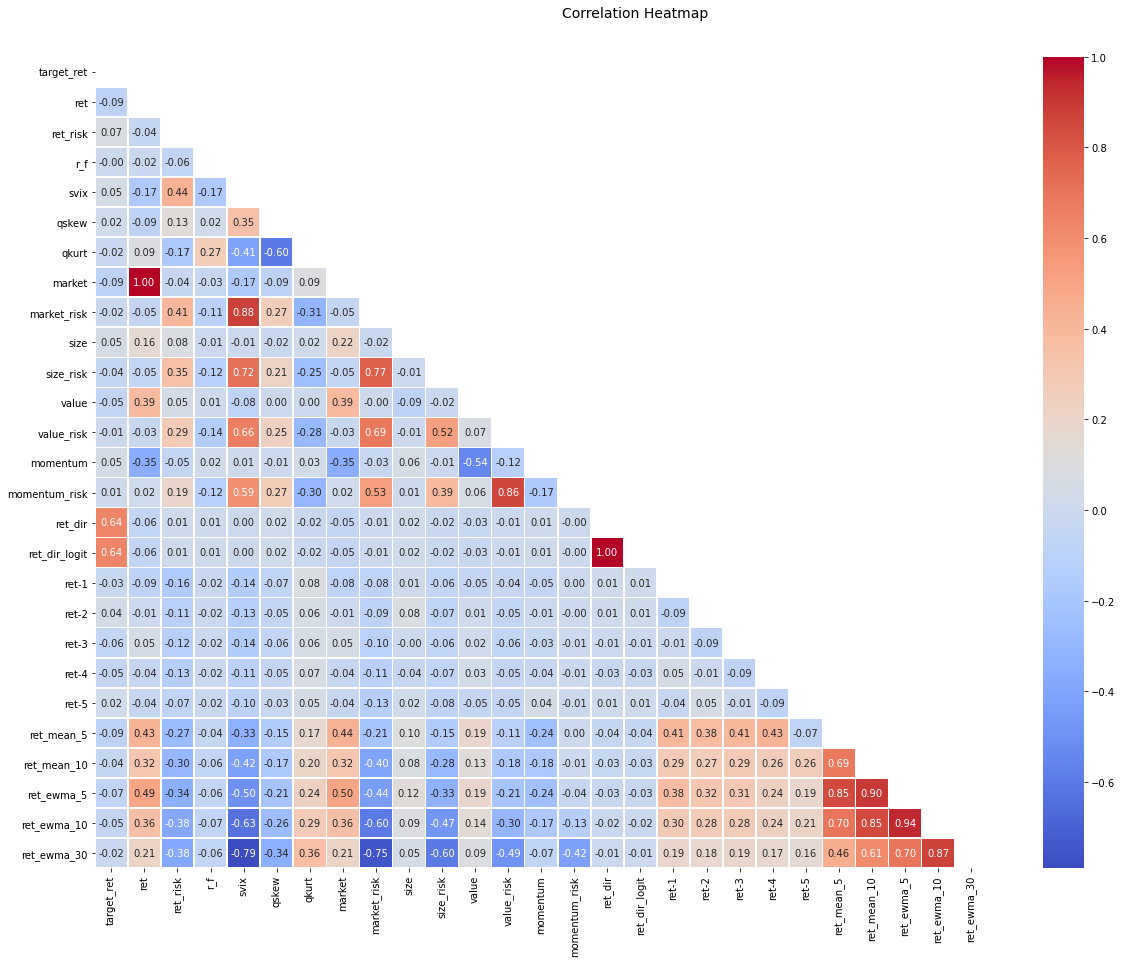

In [ ]:
"""Creating a separate DataFrame without Year, Month, Day to only look at correaltion of the features"""
df2 = df.drop(columns= ['Year', 'Month', 'Day'])

f, ax = plt.subplots(figsize=(20, 14))
corr = df2.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=0.5, mask=mask)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap', fontsize=14)
#manual format setting
ax.set_ylim(len(corr),0)

The provided code snippet creates a correlation heatmap plot for a DataFrame named df2.

The code creates a new DataFrame called df2 by removing specific columns ('Year', 'Month', and 'Day') from the original DataFrame df. The goal of this step is to create a separate DataFrame that focuses solely on the remaining features, excluding the time-related columns. In this way, the code narrows down the data to only consider correlations among these selected features.

This code displays a correlation heatmap of the features in DataFrame df2 using a plot. This plot is larger (20 by 14) to accommodate a potentially larger number of features, ensuring a clear visualization of the correlation matrix.

In order to calculate the correlation matrix, the code calculates the pairwise correlations between all pairs of features in the DataFrame df2. A correlation matrix shows the strength and direction of the linear relationship between two features. Identifying potential patterns or associations in the data can be achieved by examining the relationships and dependencies between the features.

The code creates a mask to enhance the visual representation of the correlation matrix. In the upper triangular part, the mask is a boolean matrix of the same shape as the correlation matrix. Due to the symmetric nature of the correlation matrix, this mask hides the upper triangular part of the correlation matrix when plotting a heatmap.

The correlation heatmap plot is generated using the seaborn (sns) library's heatmap() function. The heatmap visualizes the correlation matrix, with each cell colored according to its correlation value. Colormap "coolwarm" assigns cool colors (blue) to low correlation values, warm colors (red) to high correlation values, and intermediate colors to moderate correlation values. Furthermore, the code provides precise information about correlation strengths by annotating the rounded correlation values within each cell.

Using f.subplots_adjust(), the code adjusts the top margin to ensure the heatmap plot displays properly. A sufficient amount of space is provided at the top of the plot to accommodate the title and annotations without any overlap or cropping.

Code sets the plot title as "Correlation Heatmap" with a font size of 14, describing the plot's purpose and content clearly. In analyzing correlations between selected features, the title helps to clarify the plot's nature and relevance.

As a final step, the code manually adjusts the y-axis limits of the plot to match the correlation matrix's length. The adjustment ensures that all rows of the correlation matrix are correctly displayed on the y-axis, preventing data loss.

By removing time-related columns from the original DataFrame df, this code snippet creates a separate DataFrame df2. To visually represent the pairwise correlations between the selected features, the correlation heatmap plot is generated. This code provides insight into the relationships and dependencies between features by calculating the correlation matrix, applying a mask to hide redundant information, creating the heatmap, and adjusting the plot layout. Using the plot, one can understand the correlation patterns, strengths, and directions between selected features, which facilitates further analysis, decision-making, and exploration.

Lagged returns do not have a linear relationship. For some of our engineered trend features, such as There is a strong linear dependence between the means of returns, which could lead to multicollinearity. This problem is mitigated by the PCA introduced later.

For predicting the return direction (y), we compile different groups of features (X_group):

The first. The following features are included: 2. 3. Forward looking (Risk-free rate and moments of risk neutral density) Taking a look backwards (factors and returns) 4. There are five factors to consider: size, value, momentum returns and risks, as well as the last return and the risk-free rate. Simple and exponential moving averages of returns (lagged returns)

In [ ]:
y = df['ret_dir']
y_logit = df['ret_dir_logit']
X_all = df[['ret','r_f','svix','qskew','qkurt','market_risk','size','size_risk','value','value_risk','momentum','momentum_risk','ret-1','ret-2','ret-3','ret-4','ret-5','ret_mean_5','ret_mean_10','ret_ewma_5','ret_ewma_10','ret_ewma_30']]
X_forward = df[['r_f','svix','qskew','qkurt']]
X_backward = df[['ret','market_risk','size','size_risk','value','value_risk','momentum','momentum_risk','ret-1','ret-2','ret-3','ret-4','ret-5','ret_mean_5','ret_mean_10','ret_ewma_5','ret_ewma_10','ret_ewma_30']]
X_factors = df[['ret','market_risk','size','size_risk','value','value_risk','momentum','momentum_risk']]
X_returns = df[['ret','ret-1','ret-2','ret-3','ret-4','ret-5','ret_mean_5','ret_mean_10','ret_ewma_5','ret_ewma_10','ret_ewma_30']]

This code snippet assigns specific columns from a DataFrame named df to different variables and creates subsets of columns as separate DataFrames.

In the first step, the code assigns the values of the 'ret_dir' column from the DataFrame DF to a variable called 'y'. In predictive modeling, this variable represents the target variable or the dependent variable. The directional information captures the direction of predicted or modeled returns.

The code assigns the values of the 'ret_dir_logit' column from the DataFrame df to a variable called 'y_logit'. Another form of the target variable that might be suitable for logistic regression or binary classification is represented by this variable. The method is typically used when assigning binary labels or probabilities to predictions.

By selecting specific columns from the original DataFrame, the code creates several new DataFrames.

A DataFrame named 'X_all' is created by selecting multiple columns that represent different features. Among them are 'ret', 'r_f', 'svix', 'qskew', 'qkurt', 'market_risk', 'size', 'size_risk', 'value', 'value_risk', 'momentum', 'momentum_risk', 'ret_mean_5', 'ret_mean_10', 'ret Providing a comprehensive set of variables to explore potential relationships and patterns, this DataFrame contains all the features available for modeling purposes.

A second DataFrame named 'X_forward' is created by selecting a subset of columns including 'r_f', 'svix', 'qskew', and 'qkurt'. DataFrame containing a subset of features useful for forward-looking or predictive modeling. The research focuses on variables that could be useful in predicting future outcomes.

In the same way, 'X_backward' is a DataFrame created by selecting another subset of columns from df. This includes 'ret', 'market_risk', 'size', 'size_risk', 'value', 'value_risk', 'momentum', 'momentum_risk', 'ret-1', 'ret-2', 'ret-3', 'ret-4', 'ret-5', 'ret_mean_5', 'ret_mean_10' A subset of these features can be used for backward-looking or historical modeling. The model focuses on past returns, market risks, sizes, values, momentum, and their respective risks.

Additionally, 'X_factors' is a DataFrame comprised of a subset of columns, including 'ret', 'market_risk', 'size', 'size_risk', 'value', 'value_risk', 'momentum', and 'momentum_risk'. This DataFrame represents a subset of features related to specific factors or characteristics that may influence modeling. In this way, variables representing factors or attributes of particular interest or relevance can be narrowed down.

Lastly, 'X_returns' is a DataFrame created by selecting 'ret', 'ret-1', 'ret-2', 'ret-3', 'ret-4', 'ret-5', 'ret_mean_5', 'ret_mean_10', 'ret_ewma_5', 'ret_ewma_10', and ' DataFrame for lagged or moving average returns captures historical return information that may be relevant to modeling. Using previous periods or moving averages of returns, it analyzes potential patterns or dependencies.

As all further steps must be performed separately, we must divide the data into training and test sets. Our test set consists of the last 30% of entries, not a random selection from the middle of the data set, so we need to set shuffling to false.

In [ ]:
y_train, y_test = train_test_split(y, shuffle= False, test_size=0.3)

In the provided code snippet, the target variable 'y' is split into two separate sets: 'y_train' and 'y_test'. In machine learning and data analysis, this type of splitting is commonly used.

The code utilizes machine learning libraries' 'train_test_split' function to facilitate the splitting. It divides the 'y' values randomly into two sets: the training set ('y_train') and the testing set ('y_test').

For training purposes, the 'y_train' set contains a portion of the original 'y' values. Using this set, you can train a predictive model or perform any analysis that requires training data. Models can make predictions and draw conclusions based on patterns and relationships in the 'y_train' set.

The 'y_test' set, on the other hand, contains the remaining values of 'y'. As testing data, this set is used to evaluate the performance of the trained model or validate the analysis. By assessing how well the model generalizes to new, unseen data, its effectiveness can be unbiasedly evaluated.

The 'shuffle' parameter is set to 'False' in this code snippet. In other words, the order of the 'y' values is not shuffled during the splitting process, and the original order is maintained. As a result of the deterministic splitting, reproducibility is assured, which is beneficial in scenarios where the order of observations holds significance, such as time series data.

'test_size' is set to 0.3 or 30%, which means the testing set ('y_test') will contain 30% of the original 'y' values, while the training set ('y_train') will contain 70%.

This code snippet splits the target variable 'y' into 'y_train' and 'y_test'. When training a model or performing analysis, 'y_train' is used, while 'y_test' is used to evaluate the model's performance. Using deterministic splitting without shuffling preserves the original order of 'y' values, and test size determines how much data is allocated to testing. Using this splitting strategy, machine learning and data analysis tasks can be trained, evaluated, and validated effectively.

In [ ]:
y_logit_train, y_logit_test = train_test_split(y_logit, shuffle= False, test_size=0.3)

This code snippet splits the target variable 'y_logit' into two separate sets: 'y_logit_train' and 'y_logit_test'. For binary classification problems, this type of splitting is commonly used in machine learning and data analysis.

Machine learning libraries typically provide the 'train_test_split' function, which facilitates the splitting. The 'y_logit' values are randomly divided into two sets: the training set ('y_logit_train') and the testing set ('y_logit_test').

It contains a portion of the original 'y_logit' values and is used for training. Using it as training data, one can build a binary classification model or perform any analysis that requires labeled data. To learn the patterns and relationships between the independent variables and the binary target variable, we use this set.

The 'y_logit_test' set contains the remaining values of 'y_logit'. It is used to evaluate the performance of the trained binary classification model or validate the analysis results. One can gain insights into the model's ability to classify new instances accurately by assessing how well it generalizes to new, unseen data in the y_logit_test set.

This particular code snippet splits with the 'shuffle' parameter set to 'False'. In other words, the order of the 'y_logit' values is not shuffled during the splitting process. In scenarios where the order of observations is significant, such as time series or sequential data, this deterministic splitting allows reproducibility.

This indicates that the testing set ('y_logit_test') will contain 30% of the original 'y_logit' values, while the training set ('y_logit_train') will contain the remaining 70%.

This code snippet splits the binary target variable 'y_logit' into two sets: 'y_logit_train' and 'y_logit_test'. The 'y_logit_train' function trains a binary classification model or performs analysis, while the 'y_logit_test' function evaluates the model's performance or validates analysis results. The deterministic splitting without shuffling preserves the original order of 'y_logit' values, and the specified test size determines how much data is allocated to the testing set. In binary classification tasks, this splitting strategy enables effective model training, evaluation, and validation.

In [ ]:
X_all_train, X_all_test = train_test_split(X_all, shuffle= False, test_size=0.3)

The provided code snippet splits the feature set 'X_all' into two sets: 'X_all_train' and 'X_all_test'. To create training and testing datasets, this type of splitting is commonly used in machine learning and data analysis.

Machine learning libraries typically provide the 'train_test_split' function, which facilitates splitting. Randomly divides the feature set 'X_all' into two sets: training ('X_all_train') and testing ('X_all_test').

For training purposes, the 'X_all_train' set contains some of the original features from 'X_all'. The input data is used to train a machine learning model or perform any analysis that requires labeled or unlabeled data training. In order to make predictions or draw conclusions, the model learns patterns and relationships between the features in 'X_all_train'.

In contrast, the 'X_all_test' set contains the remaining features from 'X_all'. Testing data is used to evaluate the performance of the trained machine learning model or validate the analysis results. One can measure the model's ability to make accurate predictions on unseen instances by assessing how well it generalizes to new, unknown data in the 'X_all_test' set.

The 'shuffle' parameter is set to 'False' in this code snippet. The original order of the features in 'X_all' is not shuffled during the splitting process. In scenarios where the order of observations or features holds significance, such as time series data, this deterministic splitting ensures reproducibility.

It indicates that the testing set ('X_all_test') will contain 30% of the original features from 'X_all', while the training set ('X_all_train') will contain the remaining 70%.

In [ ]:
X_forward_train, X_forward_test = train_test_split(X_forward, shuffle = False, test_size = 0.3)

The provided code snippet splits the feature set 'X_forward' into two separate sets: 'X_forward_train' and 'X_forward_test'. To create training and testing datasets, this type of splitting is commonly used in machine learning and data analysis.

Machine learning libraries typically provide the 'train_test_split' function to facilitate the splitting. The function randomly divides the feature set 'X_forward' into two sets: training ('X_forward_train') and testing ('X_forward_test').

For training purposes, 'X_forward_train' contains a portion of the original features from 'X_forward'. This data is used to train a machine learning model or to perform any analysis that requires labeled or unlabeled data training. To make predictions or draw conclusions, the model learns patterns and relationships between the features in 'X_forward_train.

The 'X_forward_test' set contains the remaining original features from 'X_forward'. Testing data is used to evaluate the performance of a trained machine learning model or to validate analysis results. Analyzing how well the model generalizes to new, unseen data in the 'X_forward_test' set can give insight into the model's ability to make accurate predictions.

The 'shuffle' parameter is set to 'False' in this code snippet. The order of the features in 'X_forward' is not shuffled during the splitting process. In situations such as time series data, this deterministic splitting ensures reproducibility and is particularly useful.

It indicates that the testing set ('X_forward_test') will contain 30% of the original features from 'X_forward', while the training set ('X_forward_train') will contain the remaining 70%.

In [ ]:
X_backward_train, X_backward_test = train_test_split(X_backward, shuffle = False, test_size = 0.3)

This code snippet splits the feature set 'X_backward' into two separate sets: 'X_backward_train' and 'X_backward_test'. To create training and testing datasets, this type of splitting is commonly used in machine learning and data analysis.

In order to facilitate the splitting, the code utilizes the 'train_test_split' function, typically provided by machine learning libraries. 'X_backward' is randomly divided into two sets: the training set ('X_backward_train') and the testing set ('X_backward_test').

'X_backward_train' contains a portion of 'X_backward''s original features and is used for training. The data is used for training a machine learning model or performing any analysis that requires labeled or unlabeled data training. To make predictions or draw conclusions, the model learns patterns and relationships between features in 'X_backward_train'.

In contrast, the 'X_backward_test' set contains the remaining features from 'X_backward'. As testing data, it is used to evaluate the performance of the trained machine learning model or to validate the results of the analysis. One can gain insight into the model's ability to make accurate predictions on unseen instances by assessing how well it generalizes to new, unseen data in the 'X_backward_test' set.

The 'shuffle' parameter is set to 'False' in this specific code snippet. The order of the features in 'X_backward' is not shuffled during the splitting process. In time series data, the order of observations or features is particularly important, so this deterministic splitting ensures reproducibility.

Test_size is set to 0.3, indicating that the testing set ('X_backward_test') will contain 30% of the original features from 'X_backward', while the remaining 70% will be assigned to the training set ('X_backward_train').

In [ ]:
X_factors_train, X_factors_test = train_test_split(X_factors, shuffle = False, test_size = 0.3)

This code splits a dataset called "X_factors" into two parts: a training set and a test set.

X_factors_train is the portion of the data that will be used to train a machine learning model. A subset of the original dataset is used to teach the model patterns and relationships.

"X_factors_test" is the remaining portion of the dataset that is not included in the training set. In this set, the trained model is evaluated for performance and generalization ability. This allows us to assess the model's ability to predict unseen data.

"train_test_split" is used to split the test. "Shuffle" is set to "False," indicating that the data is not randomly shuffled before splitting. Both training and test sets will maintain the order of the data points in the original dataset.

With "test_size" set to 0.3, 30% of the data will be allocated to the test set, and 70% to the training set.

The code facilitates the partitioning of the "X_factors" dataset into two subsets, allowing the training and evaluation of a machine learning model on different sets of data.

In [ ]:
X_returns_train, X_returns_test = train_test_split(X_returns, shuffle = False, test_size = 0.3)

This code splits a dataset called "X_returns" into two parts: a training set and a test set.

X_returns_train contains a subset of the original dataset and is used to train a machine learning model. The training phase allows the model to learn patterns and relationships within the data.

The test set, denoted as "X_returns_test," includes the remaining portion of the dataset that was not included in the training set. This test set assesses the trained model's performance and generalization capabilities. The model can be evaluated based on how well it predicts unseen data or makes accurate inferences.

The "train_test_split" function is used to split the dataset. The "shuffle" parameter is set to "False," which means that the data points within the dataset will not be randomly rearranged before splitting. Consequently, both the training and test sets will maintain the order of the data points in the "X_returns" dataset.

"test_size" is set to 0.3, which means that 30% of the data will be allocated to the test set, while the remaining 70% will be allocated to the training set.

Essentially, this code divides the "X_returns" dataset into two subsets: one for training and one for evaluating a machine learning model's performance.

Scaling of features

We can see from the table above that the features have very different scales, and some are orders of magnitude apart.

Support Vector Machines and Logistic Regression, which we use, are sensitive to feature scale. SVMs, for example, are highly sensitive to the scale of features (Zheng et al., 2018).

If the features are not scaled, the features with large values will dominate other features, harming the performance of the model.

Random forests, however, are not sensitive to input scale in tree-based machine learning models.

For our features, we use Min-Max Scaling. All values of a feature are linearly scaled into the interval [0, 1]. For scaling, we use Scikit-learn.

Our final test set should be held out before scaling. Scalers are only fitted to training sets. A scaler fitted to the training set is then used to scale the test set. In reality, unseen data would also be scaled this way. As a result, we prevent information from leaking from the test set to the training set.

In [ ]:
minmaxscaler = MinMaxScaler()

This code initializes a MinMaxScaler object called "minmaxscaler".

Data preprocessing techniques such as MinMaxScaler are commonly used in machine learning and data analysis. In a dataset, it is used to map numeric features into a specified range, usually between 0 and 1.

As a result, the MinMaxScaler subtracts the minimum value of the feature, then divides by the difference between the maximum and minimum values. It preserves the relative relationships and proportions between the original values while ensuring that the transformed values fall within the desired range.

The code creates an instance of the MinMaxScaler class to enable the subsequent use of its methods and functionalities to perform the scaling operation. A scaler object can be utilized to preprocess features or variables before feeding them into a machine learning model, ensuring that they are appropriately scaled and improving accuracy.

In [ ]:
minmaxscaler.fit(X_all_train)
X_all_scaled_train = minmaxscaler.transform(X_all_train)
X_all_scaled_test = minmaxscaler.transform(X_all_test)

Data scaling is performed using the MinMaxScaler on two sets of data: "X_all_train" and "X_all_test."

The MinMaxScaler's "fit" method is called first with the input "X_all_train". In this step, the minimum and maximum values of each feature in the training set are calculated and saved.

The "transform" method is then applied to "X_all_train" using the previously fitted MinMaxScaler. The values of each feature in "X_all_train" are scaled according to the calculated minimum and maximum values. "X_all_scaled_train" stores the transformed data.

This time, the "transform" method is applied to the test set "X_all_test." The same MinMaxScaler instance is used to ensure consistency. "X_all_scaled_test" stores the transformed test data.

To determine the minimum and maximum values for each feature, the code first fits the MinMaxScaler to the training set. With the fitted scaler, it applies the scaling transformation to both the training and test sets. Based on the training set's characteristics, both sets are scaled consistently within a specified range, typically between 0 and 1.

In [ ]:
minmaxscaler.fit(X_forward_train)
X_forward_scaled_train = minmaxscaler.transform(X_forward_train)
X_forward_scaled_test = minmaxscaler.transform(X_forward_test)

Data scaling is performed using the MinMaxScaler on two sets of data related to a feature called "X_forward": "X_forward_train" and "X_forward_test."

As a first step, the MinMaxScaler's "fit" method is invoked with the input "X_forward_train". For scaling the data, the minimum and maximum values of each feature in the training set are calculated and stored.

After that, the "transform" method is applied to "X_forward_train" using the previously fitted MinMaxScaler. Based on the calculated minimum and maximum values, this operation scales the values of each feature in "X_forward_train". "X_forward_scaled_train" stores the scaled data.

This time, we use the "transform" method on the test set, "X_forward_test." The MinMaxScaler instance is used to ensure consistency. In the variable "X_forward_scaled_test," the transformed test data is stored.

The code calculates the minimum and maximum values for each feature by fitting the MinMaxScaler to the training set. Using the fitted scaler, the scaling transformation is applied to both training and test sets. The values in both sets are scaled consistently within a specified range, typically between 0 and 1, based on the characteristics of the training set.

In [ ]:
minmaxscaler.fit(X_backward_train)
X_backward_scaled_train = minmaxscaler.transform(X_backward_train)
X_backward_scaled_test = minmaxscaler.transform(X_backward_test)

This code performs data scaling using MinMaxScaler on two sets of data associated with a feature called "X_backward": "X_backward_train" and "X_backward_test."

In the first step, the MinMaxScaler's "fit" method is called with the input "X_backward_train". For scaling the data, we calculate and save the minimum and maximum values of each feature in the training set.

Using the previously fitted MinMaxScaler, the "transform" method is applied to "X_backward_train". Based on the calculated minimum and maximum values, this operation scales the values of each feature in "X_backward_train". "X_backward_scaled_train" stores the transformed data.

Once again, the "transform" method is utilized, but this time on the "X_backward_test." The same MinMaxScaler instance ensures consistency. In the variable "X_backward_scaled_test," the transformed test data is saved.

For each feature, the code first fits the MinMaxScaler on the training set. With the fitted scaler, the scaling transformation is applied to both the training and test sets. Based on the characteristics of the training set, the values in both sets are scaled consistently within a specified range, typically between 0 and 1.

In [ ]:
minmaxscaler.fit(X_factors_train)
X_factors_scaled_train = minmaxscaler.transform(X_factors_train)
X_factors_scaled_test = minmaxscaler.transform(X_factors_test)

Two data sets related to a feature called "X_factors" are scaled using the MinMaxScaler: "X_factors_train" and "X_factors_test."

In the first step, the MinMaxScaler's "fit" method is called with the input "X_factors_train". To scale the data, we calculate and store the minimum and maximum values of each feature in the training set.

Using the previously fitted MinMaxScaler, the "transform" method is used on "X_factors_train". Based on the calculated minimum and maximum values, this operation scales the values of each feature in "X_factors_train". The scaled data is then stored in the variable "X_factors_scaled_train."

In the same manner, the "transform" method is invoked again, but now on the test set "X_factors_test." To ensure consistency, the same instance of MinMaxScaler is used. "X_factors_scaled_test" stores the transformed test data.

Essentially, the code fits the MinMaxScaler to the training set to determine the minimum and maximum values for each feature. Using the fitted scaler, it applies the scaling transformation to both the training and test sets. Based on the characteristics of the training set, the values in both sets are scaled consistently within a specified range, typically 0 to 1.

In [ ]:
minmaxscaler.fit(X_returns_train)
X_returns_scaled_train = minmaxscaler.transform(X_returns_train)
X_returns_scaled_test = minmaxscaler.transform(X_returns_test)

Data scaling is performed using the MinMaxScaler on two sets of data associated with a feature named "X_returns": "X_returns_train" and "X_returns_test."

The MinMaxScaler's "fit" method is called first with the input "X_returns_train". To scale the data, the minimum and maximum values of each feature in the training set are calculated and stored.

The "transform" method is then applied to "X_returns_train" using the MinMaxScaler previously fitted. The values of each feature in "X_returns_train" are scaled based on their calculated minimum and maximum values. "X_returns_scaled_train" stores the scaled data.

To ensure consistency in scaling, the same MinMaxScaler instance is employed again with the "transform" method on the test set "X_returns_test." "X_returns_scaled_test" stores the transformed test data.

The code determines each feature's minimum and maximum values by fitting the MinMaxScaler on the training set. Using the fitted scaler, it applies the scaling transformation to both training and test sets. Based on the characteristics of the training set, the values in both sets are scaled consistently within a specified range, typically between 0 and 1.

Selection of features and reduction of dimensions

Feature selection is most important for high-dimensional problems (p>>N). By selecting only relevant features or feature combinations, two advantages can be achieved:

The first. By eliminating unnecessary features, noise cannot be introduced into the models 2. With fewer features, models can be more complex (for example, SVMs with non-linear kernels).

Feature selection is embedded in some machine learning methods, such as Random Forests. The SVM and Logistic Regression do not follow this rule.

Methods such as "Mutual Information" use univariate feature ranking to measure a feature's dependence on a target. Unfortunately, these measures miss dependency structures between the features, resulting in a loss of information.

Since our dataset is not high-dimensional and we already have subsets (all, forward, backward, etc), we carefully select features.

Recursive Feature Elimination (RFE) ranks features by fitted estimator coefficients and drops the least important ones. This is repeated until a specified number of features is dropped or remaining features have a specific feature importance. Our models are fitted with Sklearn RFE.

Principal Components Analysis (PCA) is often used to reduce the dimensionality of data sets. Principal components are linear feature combinations without linear dependency. The PCA then selects $k$ linear combinations that explain the most variance. Based on Minka's (2000) MLE method, we estimate $k$. Additionally, PCA mitigates the risk of multicollinearity introduced by feature engineering.

In [ ]:
pca_model = PCA(n_components = 'mle')
pca_model.fit(X_all_scaled_train)
X_pca_scaled_train = pca_model.transform(X_all_scaled_train)
X_pca_scaled_test = pca_model.transform(X_all_scaled_test)

A Principal Component Analysis (PCA) is performed on the scaled training and test sets of data, represented by variables "X_all_scaled_train" and "X_all_scaled_test."

An instance of the PCA class is created with 'mle' as the argument "n_components". Based on the "maximum likelihood estimation" method, the number of principal components will be determined automatically.

The PCA model is then fitted to the scaled training set, "X_all_scaled_train." This step calculates the principal components based on the training data, capturing the direction of maximum variance.

The "transform" method is used to project the scaled training data, "X_all_scaled_train," onto the newly calculated principal components. "X_pca_scaled_train" represents the transformed data in a new coordinate system defined by the principal components.

The same PCA model is applied to the scaled test data, "X_all_scaled_test." The transformed test data is saved in the variable "X_pca_scaled_test."

Basically, the code creates a PCA model with an automatically determined number of components. After fitting the model to the scaled training set, the transformation is applied to both the training and test sets. It allows dimensionality reduction and captures the most important patterns in the data by projecting the data onto principal components.

When we plot the variance share of each Principal Component, we see that the first three components already explain about 75% of the variation.

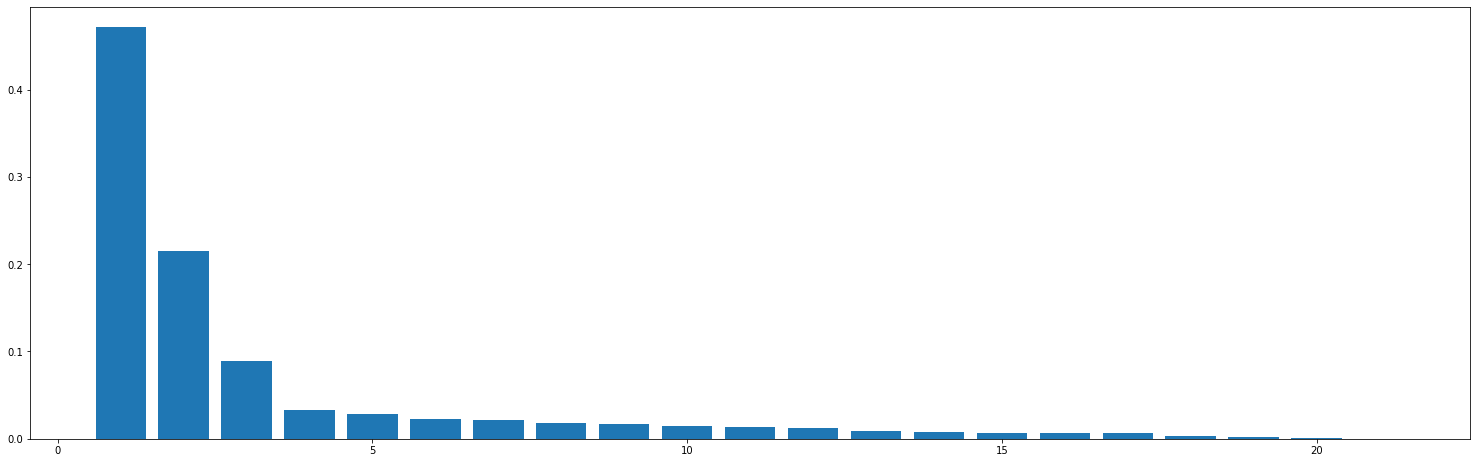

In [ ]:
fig = plt.figure(figsize= [20,6])
ax = fig.add_axes([0,0,1,1])
labl = range(1,pca_model.n_components_ + 1)
expvar = pca_model.explained_variance_ratio_
ax.bar(labl,expvar)
plt.show()

This code generates a bar plot to visualize the explained variance ratios of the principal components obtained from a PCA model previously run.

As a first step, a figure object, "fig," is created with a specific size defined by the argument [20,6]. The plot's width and height are determined by this.

The "add_axes" method is used to add an axes object, "ax," to the figure. In the figure, [0,0,1,1] specifies the position and size of the axes. It indicates that the axes should occupy the entire figure in this case.

It generates a range of numbers, "labl," starting at 1 and ending at the number of components in the PCA model plus 1. Each principal component is represented by a different number on the x-axis.

Using the "explained_variance_ratio_" attribute, the explained variance ratios of the principal components are calculated from the PCA model. Each principal component explains a specific proportion of the total variance in the data.

A bar plot is then created by calling the "ax.bar" function. "labl" provides the x-axis labels, and "expvar" provides the heights of the bars.

To display the generated bar plot, use the "plt.show()" function.

The code creates a bar plot to illustrate the explained variance ratios of the principal components. Using the plot, it is possible to visualize how each principal component contributes to the variance of the data.

Additionally, we can visualize how the features contribute to the first principal component

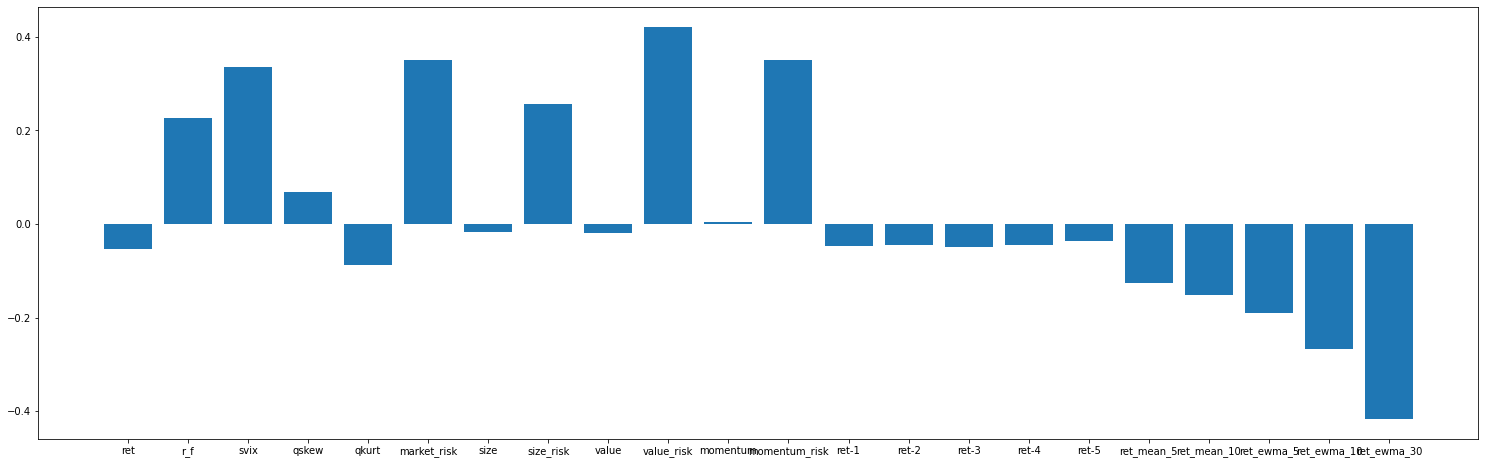

In [ ]:
fig = plt.figure(figsize= [20,6])
ax = fig.add_axes([0,0,1,1])
labl = ['ret','r_f','svix','qskew','qkurt','market_risk','size','size_risk','value','value_risk','momentum','momentum_risk','ret-1','ret-2','ret-3','ret-4','ret-5','ret_mean_5','ret_mean_10','ret_ewma_5','ret_ewma_10','ret_ewma_30']
pc1 = pca_model.components_[1,:]
ax.bar(labl,pc1)
plt.show()

Using the given code, a bar plot is generated to visualize the weights or loadings of the features in the second principal component.

The first step is to create the figure object, "fig," with a specific size defined by the argument [20,6]. Plot width and height are determined by this.

Using the "add_axes" method, an axes object, "ax," is added to the figure. In the figure, the argument [0,0,1,1] specifies the position and size of the axes. The axes should occupy the entire figure in this case.

There is a list of feature labels, "labl.". Input features to the PCA model are represented by these labels. A label corresponds to a specific variable or characteristic of the data.

By using the "components_" attribute, the weights or loadings of the features on the second principal component are obtained. Weights represent the contribution of each feature to the second principal component.

In order to create a bar plot, the "ax.bar" function is called. "labl" provides the x-axis labels, and "pc1" provides the heights of the bars.

The generated bar plot is displayed using the "plt.show()" function.

To visualize the weights or loadings of the features on the second principal component, the code generates a bar plot. According to the plot, each feature contributes to explaining the variation explained by the second principal component.

In plotting our return direction in the space of the first three Principal Components, we see that predicting it will be difficult:

Text(0.5, 0, 'PC 3')

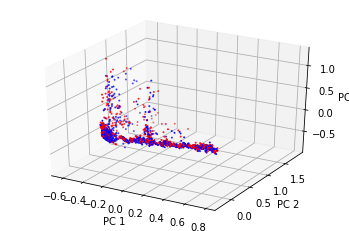

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color= ['blue' if y == 1 else 'red' for y in y_train]
ax.scatter(xs=X_pca_scaled_train[:,0], ys=X_pca_scaled_train[:,1], zs=X_pca_scaled_train[:,2], zdir='z', s=1, c=color, depthshade=True)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

Using the values from the first three principal components, the code generates a 3D scatter plot to visualize the data points.

To hold the plot, the figure object "fig" is created first.

By using the "add_subplot" method, an axes object, "ax," is added to the figure. The argument "111" specifies that there should be only one subplot in the plot. The projection is set to '3d', indicating that the plot will be rendered in three dimensions.

There is a color list, "color.". The color of each data point will be determined by the value of the "y_train" variable. The color will be blue if the value is 1, otherwise it will be red. A list comprehension is used to accomplish this.

To create the scatter plot, the "ax.scatter" function is called. Data points along the three axes are represented by the arguments "xs," "ys," and "zs," which come from the transformed training data, "X_pca_scaled_train." The "zdir" parameter indicates that the data points should be projected onto the z-axis. The size ('s'), color ('c'), and depth shading ('depthshade') of the marker are also specified.

The "ax.set_xlabel," "ax.set_ylabel," and "ax.set_zlabel" functions set the labels for the x-axis, y-axis, and z-axis, respectively.

With the values from the first three principal components, the code generates a 3D scatter plot to visualize the data points. Each data point's color is determined by its "y_train" value. Plotting the transformed principal component space provides insight into the distribution and relationships between data points.

AI (machine learning)

As we've walked you through our data and preprocessing, it's time for more machine learning vocabulary.

In addition, we will guide you through the process of finding the best model for your needs. As a result, we will refer to this as the "machine learning pipeline". Using our different algorithms, we will explain our course of action. Preprocessing and selecting the best features are the first steps. We then split our data into training and testing. See MÃ¼ller et al., 2016 for more information.


Data splitting for training and testing

    Machine learning requires you to evaluate or confirm that your models deliver good forecasts fairly quickly. Holding back a part of the data from training can be used as an unseen test set to test the found model. Two questions arise from this.

    How do we select the values for our test data set? Data for the test dataset can be selected in two ways. First, we can use a random variable to select random indexes until a predefined percentage of our dataset is included in the test. You can also select the data values you want to test manually.

    As our basic data set for machine learning, we have a time series. Due to our interest in predicting future values, we are selecting our test data set using the second method explained above. Our test dataset was selected at the end of the time series.

    Second, how large should the test data set be as a percentage of the entire dataset? A big test data set could result in a more robust validation but can decrease the amount of data available for the model training, which could result in a very poor performing model. There is then an optimization problem of finding the best trade-off between having more data to train or having a more robust validation. To solve this optimization problem, there are some approaches to calculating the best ratio between train and test sets. Considering that ratios between 25-35% are very common, we decided to take a test size of 30% of our basic data set.

    Sklearn's train_test_split method is used to split our train and test data sets. Our test data set size is defined by the parameter test_size. For our 30%, we set it to 0.3. The method takes the 30% automatically from the end of the dataframe, but shuffles them first. The parameter shuffle=False prevents the shuffle and ensures that the 30% in our test set are from the end of our basic data set.


For the Random Forest, we only split the non-scaled data. Above, we have already split the scaled data.

Validation by cross-validation


    In today's machine learning processes, cross-validation is essential to evaluating the accuracy of models. Machine learning models typically receive part of the total data available for training and are tested and evaluated using the remaining data. There is a possibility that the retained test data contain strong outliers from the model or can only be predicted poorly using the model due to other factors. It would normally be considered a bad model because it did not perform well on the test data set, regardless of how well it predicted the data in the training data set. Cross-validation can close this gap. The cross-validation test determines how well the model predicts data that was not used for training. As a result, selection bias or overfitting and underfitting can be detected.

    K-fold cross-validation is one of the most common cross-validation methods. Using the remaining k-1 sets, the training set is divided into k complementary sets and validated for each. It means that 8 models are trained and tested for k = 8. As a result of cross-validation, the average ability of the 8 models to predict unseen data is calculated. Most users perform K-fold cross-validation without knowing if it makes sense for the data set.

    We are working with S&P 500 time series data. Financial data, of course, is more interested in predicting future events than finding a model that explains past data. We are dealing with time series data, which makes most cross-validation methods difficult because they randomly select the amounts used for training and validation. As a result, it violates one of the basic assumptions of cross-validation, namely the assumption that the data are independent.

    Sklearn provides another method that does not violate data independence. K quantities are also included in the data set. It must be noted, however, that these quantities are not chosen randomly or overlapping, but contiguous based on the time series. Using the first observation set, training is carried out and tested and validated using the second observation set. Based on this, an error measure is created. As a next step, training is performed on the basis of the first two sets of observations, followed by testing and validation on the basis of the third, and a new error measure is calculated. After k iterations, an average error measure is calculated. Because we use all the data available for cross-validation, we can ensure that the data is independent so as not to violate the basic cross-validation assumptions.

    We define tscv as our TimeSeriesSplit method with the parameter n_splits = 5, which divides our data into 5 sets. However, Bergmeir et al. (2018) find that K-fold CV can be used for pure autoregressive models, but since our model is not purely autoregressive, we continue using TimeSeriesSplit. The K-fold-CV could be investigated for one of our models in the future.

In [ ]:
tscv = TimeSeriesSplit(n_splits = 5)

It initializes a time series cross-validation object called "tscv" with a specified number of splits.

"TimeSeriesSplit" is a specialized cross-validation technique designed for time series data. Based on the temporal order of the data, it divides the data into sequential, non-overlapping folds or subsets.

As the "n_splits" parameter is set to 5, the time series data will be divided into five consecutive and non-overlapping folds. During cross-validation, each fold will serve as a training and test set combination.

When dealing with time-dependent data, time series cross-validation is particularly useful, since it allows machine learning models to be evaluated in a more realistic and reliable manner. When a model is applied to unseen future time points, the temporal nature of the data can help determine how well it can handle forecasting and prediction tasks.

This code initializes a time series cross-validation object, "tscv," with a specified number of splits, allowing machine learning models to be evaluated on time series data.

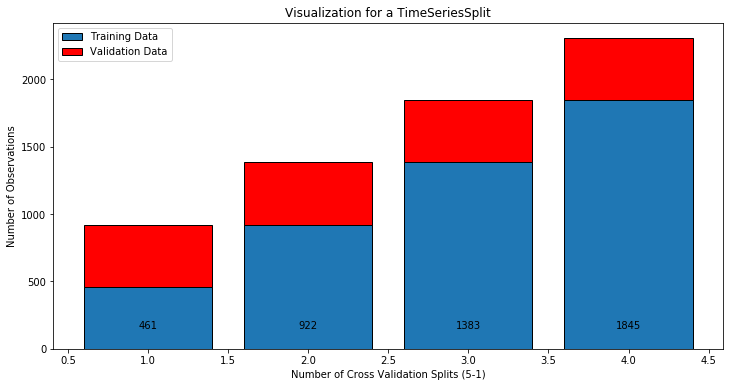

In [ ]:
tscv_splits = 5
split_size = (0.7 * len(df['ret'])) / tscv_splits

train_data = [0] * (tscv_splits - 1)
test_data = [split_size] * (tscv_splits - 1)
bar_label = [0] * (tscv_splits - 1)

for i in range(len(train_data)):
    train_data[i] = split_size * (i + 1)
    bar_label[i] = split_size * (i + 1)

bar_label = ['%.0f' % elem for elem in bar_label]
labels = np.arange(1, tscv_splits).tolist()

fig, ax = plt.subplots(figsize=(12, 6))

P = ax.bar(labels, train_data, label='Training Data', edgecolor='black')
P = ax.bar(labels, test_data, bottom=train_data, label='Validation Data', color='red', edgecolor='black')
def autolbl(rects):
    for i, rect in enumerate(P):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 0.3 * height, bar_label[i], ha='center', va='bottom', rotation=0)
autolbl(P)
ax.set_ylabel('Number of Observations')
ax.set_xlabel('Number of Cross Validation Splits (' + str(tscv_splits) + '-1)')
ax.set_title('Visualization for a TimeSeriesSplit')
ax.legend()

plt.show()

Using the provided code, a bar chart visualization of time series cross-validation (TSCV) is generated.

The code defines the number of splits, "tscv_splits," which determines how the data will be divided for cross-validation into folds or subsets.

"Split_size" is calculated by dividing 70% of the 'ret' column in the DataFrame 'df' by the number of splits.

In the following steps, three lists are initialized: 'train_data,' 'test_data,' and 'bar_label.' These lists are initially filled with zeros, and their lengths are equal to 'tscv_splits' minus one.

Based on the split sizes, a loop populates the 'train_data,' 'test_data,' and 'bar_label' lists with appropriate values. It assigns the corresponding values to each element of the list from 0 to the length of 'train_data'.

After formatting adjustments are made to the 'bar_label' list, the elements are converted to integers and assigned string labels.

Using the 'figsize' argument, the code creates a figure and axes object for the plot.

By using the axes object, the code generates two sets of bars on the plot: one for training and one for validation. Using the 'autolbl' function, each bar is labeled with the corresponding split size.

For the plot, additional formatting is applied to the axes labels, title, and legend.

The plot is displayed using the 'plt.show()' function.

This code generates a bar chart that illustrates a time series cross-validation scheme. A visual representation of how cross-validation data is partitioned for training and validation is provided by the size of training and validation data for each split.

Tuning hyperparameters

Choosing the right features is not enough. A good result depends on adjusting the settings of your model beforehand. From now on, we'll refer to these settings as hyperparameters.

The best hyperparameters can be found in a variety of ways. This task can be accomplished using two established methods. Our machine learning models will later use them. (MÃ¼ller et al., 2018).


GridSearch involves setting up a grid of hyperparameter values and training a model for each combination. Expensive execution in terms of both computing power and time.


Randomized Search The user sets a grid of hyperparameter values and selects random combinations to train and score the model. Explicit control over parameters and iterations possible. Randomized search is recommended for large data sets, but does not yield optimal results.

Model evaluation


We want to measure the quality of our results after we have trained our model. There are a variety of metrics available for this purpose. In "---", we will refer to a selection. For now, we will introduce you to 'accuracy', which is calculated by dividing all results correctly labeled by the model by the number of data points. (see Hastie et al., 2017)
<center><br>
    <big><big>
        $Accuracy =\frac{True Positive + True Negative}{True Positive + True Negative + False Positive + False Negative}$
</big></big>
</center><br>
  

As it is equally important to classify ups and downs correctly when trading in the market, accuracy is the best way to evaluate our models.

The support vector machine


Background theory

Support Vector Machines construct hyperplanes

In other words, f(x) = \beta_{0} + \beta_{1}x_{1} + ... The /beta_[p]x_[p]$

In the vector space of $p$ features, that serves as the decision function and linearly separates the two classes of data points ($y /in /left/[1,-1 /right/]$).

The linearly separable case has a margin $ M $, i.e. It maximizes the minimum euclidean distance between any observation and the separating hyperplane.

As a result of non-separability, the Margin becomes soft. Tolerance for margin violations is determined by the cost parameter $C$. These violations are training observations can be misclassified or within the margin. The following figure illustrates a soft margin with some violations:

Tuning and fitting hyperparameters

The first step is to initialize the SVMs with the different kernels:

In [ ]:
model_linear = SVC(kernel = 'linear', cache_size = 6000, class_weight = 'balanced')

This code creates a linear kernel support vector machine (SVM) model.

SVM models are defined by the "SVC" class. If the "kernel" parameter is specified as 'linear', then the model will use a linear kernel function, which creates linear decision boundaries between classes.

During model training, "cache_size" is set to 6000, indicating how much memory will be allocated for caching data. For large datasets, a larger cache size can improve training efficiency.

"class_weight" is set to 'balanced', which adjusts the weights assigned to different classes. In imbalanced datasets, certain classes may have fewer instances than others. When the 'balanced' option is selected, the weights are automatically adjusted to give more weight to the minority class, thus improving model performance.

The code creates an SVM model with a linear kernel and specifies a cache size for efficient training. To handle imbalanced datasets, class weights are also applied. To find linear decision boundaries between different classes in data, this model can be used for classification tasks.

In [ ]:
model_rbf = SVC(kernel = 'rbf', cache_size = 6000, class_weight = 'balanced')

Using the provided code, a support vector machine (SVM) model with radial basis function (RBF) kernel is created.

SVM models are defined by the "SVC" class. If the "kernel" parameter is set to "rbf", the model will use an RBF kernel function, which is a popular choice for SVMs due to its ability to capture nonlinear relationships.

The "cache_size" parameter is set to 6000, which determines how much memory will be allocated for caching data during training. A larger cache size can improve training efficiency, especially for datasets with many samples.

Also, the "class_weight" parameter is set to 'balanced', which adjusts the weights assigned to different classes. When dealing with imbalanced datasets, this is particularly useful when there are unequal numbers of instances in different classes. It automatically adjusts the class weights to give more importance to the minority class, in order to mitigate the impact of class imbalance on the model's performance.

For efficient training, the code creates an SVM model with an RBF kernel. Additionally, class weights are applied to address class imbalances. As a classification model, this model can capture non-linear relationships and determine optimal decision boundaries between classes.

In [ ]:
model_poly = SVC(kernel = 'poly', cache_size = 6000, class_weight = 'balanced')

This code creates a support vector machine (SVM) model with a polynomial kernel.

A SVM model is defined by the "SVC" class. If the "kernel" parameter is set to poly, the model will use a polynomial kernel function that can capture non-linear relationships.

6000 is the cache_size parameter, which indicates how much memory is allocated for caching data during model training. For datasets with a large number of samples, allocating a larger cache size can enhance training efficiency.

Additionally, the "class_weight" parameter is set to 'balanced', which adjusts the weights assigned to different classes. It is particularly useful when dealing with imbalanced datasets in which there are unequal numbers of instances in different classes. With the 'balanced' option, the class weights are automatically adjusted to give more weight to the minority class, reducing the impact of class imbalance on the model's performance.

The code creates an SVM model with a polynomial kernel and specifies a cache size for efficient training. To address class imbalances in the dataset, class weights are also applied. The model can capture non-linear relationships and find optimal decision boundaries between classes using polynomial functions, making it suitable for classification tasks.

In [ ]:
model_sigmoid = SVC(kernel = 'sigmoid', cache_size = 6000, class_weight = 'balanced')

Using the provided code, a sigmoid kernel support vector machine model is created.

SVM models are defined by the "SVC" class. With the "kernel" parameter set to 'sigmoid', the model will use a sigmoid kernel function, which is a nonlinear function that is commonly used to solve binary classification problems.

During the training process, the "cache_size" parameter is set to 6000, which determines how much memory is allocated for caching data. Training efficiency can be improved by allocating a larger cache size, especially for datasets with a large number of samples.

In addition, the "class_weight" parameter is set to 'balanced', which adjusts the weights assigned to different classes. In imbalanced datasets, where there are unequal numbers of instances in different classes, this is particularly useful. By adjusting the class weights, the 'balanced' option aims to mitigate the impact of class imbalance on the model.

Essentially, the code creates an SVM model with a sigmoid kernel, specifying a cache size. Additionally, class weights are applied to address class imbalances. Using the sigmoid function, this model can capture non-linear relationships and is suitable for binary classification tasks.

Hyperparameter grids for rbf, polynomial, and sigmoid kernels consist of C, gamma, and degree.

In [ ]:
param_grid_linear = {'C': np.logspace(-10,4,14)}
param_grid_rbf = {'C': np.logspace(-10,4,14),
                  'gamma': np.logspace(-10,4,14)} # Also used for sigmoid kernel
param_grid_poly = {'C': np.logspace(-2,1,4),
                   'gamma': np.logspace(-3,1,5),
                   'degree': [2]}

To tune the hyperparameters of SVM models with different kernels, the code provides three parameter grids: "param_grid_linear," "param_grid_rbf," and "param_grid_poly."

A single parameter, 'C', represents the regularization parameter for the linear kernel in the "param_grid_linear" dictionary. 'C' values are generated using np.logspace(-10,4,14), which creates a sequence of 14 logarithmically spaced values between 10^-10 and 10^4. During hyperparameter optimization, these values will be tested to determine the optimal linear kernel 'C' value.

The "param_grid_rbf" dictionary is used for both the radial basis function (RBF) kernel and the sigmoid kernel. There are two parameters in this equation: 'C' and 'gamma'. 'C' represents the regularization parameter, and 'gamma' represents the Gaussian kernel width. C and Gamma are generated using np.logspace(-10,4,14), resulting in 14 logarithmically spaced values between 10^-10 and 10^4. For RBF and sigmoid kernels, these values will be explored during hyperparameter optimization.

Three parameters are included in the "param_grid_poly" dictionary for the polynomial kernel: 'C', 'gamma', and 'degree'. 'C' and 'gamma' are generated using np.logspace(-2,1,4) and np.logspace(-3,1,5), respectively, resulting in four and five values, respectively. A fixed value of 2 is set for the 'degree' parameter. During hyperparameter optimization, these parameter combinations will be evaluated to identify the best polynomial kernel 'C', 'gamma', and 'degree' values.

The code sets up parameter grids for hyperparameter tuning of linear, RBF/sigmoid, and polynomial SVM models. For each kernel type, these grids define the range of potential values for the regularization parameter ('C'), Gaussian kernel width ('gamma'), and polynomial degree ('degree').

We found that the polynomial kernels were training endlessly for some $(C,\gamma)$-combinations. As we suspect numerical instabilities, we limit the degree to $2$ and search fewer parameters. (2016) (Hsu et al.)

GridSearch is demonstrated using a RBF-Kernel SVM fitted to all features.

In [ ]:
gsearch_rbf_all = GridSearchCV(estimator = model_rbf, #estimator is a RBF-SVM
                             cv = tscv, #CrossValidation scheme is our TimeSeriesSplit from above
                             param_grid = param_grid_rbf, #parameter grid that we search over
                             n_jobs = -1, #parallel fitting on all CPU cores
                             verbose = 10) #printing some status messages during fitting

In the following code, a grid search is used to find the optimal hyperparameters for a radial basis function (RBF) support vector machine (SVM).

Grid search is performed using "GridSearchCV" class. As the basis for the grid search, the "estimator" parameter is set to "model_rbf," a SVM model with an RBF kernel.

Using the time series cross-validation scheme created earlier, the "cv" parameter is set to "tscv." As a result, the grid search is properly split and evaluated in a time-dependent manner.

Param_grid is set to "param_grid_rbf," which is the RBF kernel's parameter grid. The hyperparameters 'C' (regularization parameter) and 'gamma' (Gaussian kernel width) are included in this file.

"n_jobs" is set to -1, enabling parallel fitting on all CPU cores. Grid searches can thus take advantage of multiple cores for faster execution.

The "verbose" parameter is set to 10, which determines how many status messages are printed during the fitting process. More detailed output is indicated by a higher value, such as 10.

The code uses the GridSearchCV class to find the optimal hyperparameters for an RBF SVM model using a grid search. Model, cross-validation scheme, parameter grid, and additional settings for parallel fitting and verbosity are specified. Using the grid search, the best hyperparameters for the RBF SVM model will be identified by exploring different combinations of 'C' and 'gamma' values.

Fit the SVMs to the training data by searching the grid

In [ ]:
gsearch_rbf_all.fit(X_all_scaled_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=2000,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_gr...
       4.12462638e-02, 4.92388263e-01, 5.87801607e+00, 7.01703829e+01,
       8.37677640e+02, 1.00000000e+04]),
                         'gamma': array([1.00000000e-10, 1.19377664e-09, 1.42510267e-08, 1.70125428e-07,
       2.03091762e-06, 2.42446202e-05, 2.89426612e-04, 3.45510729e-03,
       4.12462638e-02, 4.92388263e-01, 5.87801607e+00, 7.01703829e+01,
       8.37677640e+02, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', 

This code fits the previously defined grid search, "gsearch_rbf_all," to the training data in order to find the best hyperparameters for an SVM model with a radial basis function (RBF).

"fit" is called on the grid search object, passing the scaled training data "X_all_scaled_train" and the corresponding target variable "y_train".

To train and evaluate multiple SVM models, the grid search explores different combinations of hyperparameters specified in the parameter grid. The grid search performs cross-validation using the defined time series cross-validation scheme for each combination.

Several SVM models with different hyperparameter settings are trained and evaluated during the fitting process. Each model is evaluated according to the evaluation metric (such as accuracy or area under the curve) determined by the problem.

Across cross-validated models, the grid search selects the hyperparameters that maximize the performance metric. The grid search object contains the best hyperparameters and corresponding model performance after the fitting process has been completed.

A grid search object is fitted to the training data, allowing the search for optimal hyperparameters for an SVM model with an RBF kernel to begin. Using cross-validation, the grid search evaluates multiple model variations, considering different combinations of hyperparameters.

Based on accuracy, these are the best hyperparameters

Combination-friendly

To repeat the procedure for all (Kernel,Feature Group)-combinations, follow these steps:

In [ ]:
gsearch_linear_all = GridSearchCV(estimator=model_linear, cv=tscv,
                        param_grid=param_grid_linear, n_jobs = -1)
gsearch_rbf_all = GridSearchCV(estimator=model_rbf, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)
gsearch_poly_all = GridSearchCV(estimator=model_poly, cv=tscv,
                        param_grid=param_grid_poly, n_jobs = -1)
gsearch_sigmoid_all = GridSearchCV(estimator=model_sigmoid, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)

The code provides four grid searches, each aimed at finding the optimal hyperparameters for a specific SVM model with a different kernel type: linear, RBF, polynomial, and sigmoid.

Grid search objects are defined for each kernel type using the "GridSearchCV" class. "estimator" is set to the SVM model with the appropriate kernel type: "model_linear" for linear, "model_rbf" for RBF, "model_poly" for polynomial, and "model_sigmoid" for sigmoid.

In grid search, the "cv" parameter is set to time series cross-validation, "tscv," ensuring that the data is appropriately split and evaluated in a time-dependent manner.

"param_grid" specifies the parameter grid for each kernel type: "param_grid_linear" for linear, "param_grid_rbf" for RBF and sigmoid, and "param_grid_poly" for polynomial.

Grid search can be sped up by setting the "n_jobs" parameter to -1, which allows parallel fitting across all CPU cores.

The code sets up four separate grid searches, each targeting a different SVM model and kernel. Based on their respective parameter grids, these grid searches explore different combinations of hyperparameters. Cross-validation is used to train and evaluate the models, and grid searches are used to identify the best hyperparameters.

In [ ]:
gsearch_linear_forward = GridSearchCV(estimator=model_linear, cv=tscv,
                        param_grid=param_grid_linear, n_jobs = -1)
gsearch_rbf_forward = GridSearchCV(estimator=model_rbf, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)
gsearch_poly_forward = GridSearchCV(estimator=model_poly, cv=tscv,
                        param_grid=param_grid_poly, n_jobs = -1)
gsearch_sigmoid_forward = GridSearchCV(estimator=model_sigmoid, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)

Four separate grid searches are provided in the code, each aiming to find the optimal hyperparameters for a specific SVM model with a different kernel type: linear, RBF, polynomial, and sigmoid.

Grid search objects are defined for each kernel type using the "GridSearchCV" class. It is set to the corresponding SVM model with the specific kernel type: "model_linear" for linear, "model_rbf" for RBF, "model_poly" for polynomial, and "model_sigmoid" for sigmoid.

Grid search is performed using the time series cross-validation scheme, "tscv," which ensures that the data is appropriately split and evaluated in a time-dependent manner.

Parameter grids are set for each kernel type: "param_grid_linear" for linear kernels, "param_grid_rbf" for RBF and sigmoid kernels, and "param_grid_poly" for polynomials.

With "n_jobs" set to -1, parallel fitting can be performed on all CPU cores, speeding up grid search.

Essentially, the code sets up four separate grid searches, each targeting a different SVM model and kernel. Using their respective parameter grids, these grid searches explore different combinations of hyperparameters. Time series cross-validation is used to train and evaluate the models, and grid searches are used to identify the best hyperparameters.

In [ ]:
gsearch_linear_backward = GridSearchCV(estimator=model_linear, cv=tscv,
                        param_grid=param_grid_linear, n_jobs = -1)
gsearch_rbf_backward = GridSearchCV(estimator=model_rbf, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)
gsearch_poly_backward = GridSearchCV(estimator=model_poly, cv=tscv,
                        param_grid=param_grid_poly, n_jobs = -1)
gsearch_sigmoid_backward = GridSearchCV(estimator=model_sigmoid, cv=tscv,
                        param_grid=param_grid_rbf, n_jobs = -1)

With the given code, four separate grid searches are performed, each aiming to find the optimal hyperparameters for a specific SVM model with a different kernel type: linear, RBF, polynomial, and sigmoid.

Grid search objects are defined for each kernel type using the "GridSearchCV" class. "estimator" specifies the SVM model with the specific kernel type: "model_linear" for linear, "model_rbf" for RBF, "model_poly" for polynomial, and "model_sigmoid" for sigmoid.

During grid search, the "cv" parameter is set to the time series cross-validation scheme, "tscv," which allows data to be split and evaluated in a time-dependent manner.

"param_grid" specifies the parameter grid for each kernel type: "param_grid_linear" for linear, "param_grid_rbf" for RBF and sigmoid (since they share the same parameter grid), and "param_grid_poly" for polynomial.

Grid search can be sped up by setting the "n_jobs" parameter to -1, allowing parallel fitting on all CPU cores.

There are four separate grid searches in the code, each targeting a different SVM model with a different kernel type. The grid searches explore different combinations of hyperparameters defined by their respective parameter grids. Time series cross-validation is used to train and evaluate the models, and grid searches are used to identify the best hyperparameters.

In [ ]:
gsearch_linear_all.fit(X_all_scaled_train, y_train)
gsearch_linear_forward.fit(X_forward_scaled_train, y_train)
gsearch_linear_backward.fit(X_backward_scaled_train, y_train)
gsearch_linear_factors.fit(X_factors_scaled_train, y_train)
gsearch_linear_returns.fit(X_returns_scaled_train, y_train)
gsearch_linear_pca.fit(X_pca_scaled_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=6000,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-10, 1.19377664e-09, 1.42510267e-08, 1.70125428e-07,
       2.03091762e-06, 2.42446202e-05, 2.89426612e-04, 3.45510729e-03,
       4.12462638e-02, 4.92388263e-01, 5.87801607e+00, 7.01703829e+01,
       8.37677640e+02, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

With the given code, six grid searches are fitted, each aiming to find the optimal hyperparameters for a linear SVM model.

On each grid search object, the "fit" method is called. As the first grid search, "gsearch_linear_all," fits the model using the entire training dataset scaled as "X_all_scaled_train" and the corresponding target variable "y_train."

In the remaining five grid searches, "gsearch_linear_forward," "gsearch_linear_backward," "gsearch_linear_factors," "gsearch_linear_returns," and "gsearch_linear_pca," different subsets of training data, each scaled appropriately, and the target variable "y_train," the linear SVM model was fitted.

By fitting these grid searches with different training data subsets, we can explore the performance of linear SVM models under different feature representations. In terms of the selected evaluation metric, this can help identify the most appropriate training data subset or feature space.

Essentially, the code fits six linear SVM models with different sets of training data. A specific subset of the training data, along with the target variable, is used to fit each grid search. It allows evaluating the linear SVM model's performance across different feature representations or transformations by fitting the models with different training data subsets.

In [ ]:
gsearch_rbf_all.fit(X_all_scaled_train, y_train)
gsearch_rbf_forward.fit(X_forward_scaled_train, y_train)
gsearch_rbf_backward.fit(X_backward_scaled_train, y_train)
gsearch_rbf_factors.fit(X_factors_scaled_train, y_train)
gsearch_rbf_returns.fit(X_returns_scaled_train, y_train)
gsearch_rbf_pca.fit(X_pca_scaled_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=6000,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             pa...
       4.12462638e-02, 4.92388263e-01, 5.87801607e+00, 7.01703829e+01,
       8.37677640e+02, 1.00000000e+04]),
                         'gamma': array([1.00000000e-10, 1.19377664e-09, 1.42510267e-08, 1.70125428e-07,
       2.03091762e-06, 2.42446202e-05, 2.89426612e-04, 3.45510729e-03,
       4.12462638e-02, 4.92388263e-01, 5.87801607e+00, 7.01703829e+01,
       8.37677640e+02, 1.00000000e+04])},
             pre_dispatch='2*n_jobs', 

Each grid search uses different sets of training data to find the optimal hyperparameters for an SVM model with a radial basis function (RBF) kernel.

The "fit" method is called on each grid search object. "gsearch_rbf_all" fits the RBF SVM model using the entire training dataset scaled as "X_all_scaled_train" and the corresponding target variable "y_train."

In the remaining five grid searches, namely "gsearch_rbf_forward," "gsearch_rbf_backward," "gsearch_rbf_factors," "gsearch_rbf_returns," and "gsearch_rbf_pca," different subsets of training data were used to fit the RBF SVM model, along with the target variable "y_train."

The code allows evaluating the RBF SVM model under different feature representations or transformations by fitting these grid searches with different training data subsets. As a result, the most suitable training data subset or feature space can be identified based on the selected evaluation metric.

The code fits six different RBF SVM models with different sets of training data. Grid searches are fitted using a subset of the training data and the target variable. A RBF SVM model can be evaluated across various feature representations or transformations by fitting the models with different training data subsets.

In [ ]:
gsearch_poly_all.fit(X_all_scaled_train, y_train)
gsearch_poly_forward.fit(X_forward_scaled_train, y_train)
gsearch_poly_backward.fit(X_backward_scaled_train, y_train)
gsearch_poly_factors.fit(X_factors_scaled_train, y_train)
gsearch_poly_returns.fit(X_returns_scaled_train, y_train)
gsearch_poly_pca.fit(X_pca_scaled_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=6000,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'degree': [2],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Using different sets of training data, the given code fits six separate grid searches aiming to find the optimal hyperparameters for an SVM model with a polynomial kernel.

On each grid search object, the "fit" method is called. "gsearch_poly_all" fits the polynomial SVM model using the entire training dataset scaled as "X_all_scaled_train" and the corresponding target variable "y_train.".

In the remaining five grid searches, "gsearch_poly_forward," "gsearch_poly_backward," "gsearch_poly_factors," "gsearch_poly_returns," and "gsearch_poly_pca," different subsets of the training data, each scaled accordingly, along with the target variable "y_train," are used to fit the polynomial SVM model.

The code allows evaluating the performance of the polynomial SVM model under various feature representations or transformations by fitting these grid searches with different training data subsets. In terms of the selected evaluation metric, this can help identify the best training data subset or feature space.

The code fits polynomial SVM models to six different sets of training data. Grid searches are fitted using a subset of training data and the target variable. Polynomial SVM models can be evaluated across various feature representations or transformations by fitting them with different training data subsets.

Elimination of recursive features

By selecting good features, we try to see if RFE will improve accuracy. We can only use the linear kernel for RFE because the weights of the SVM are not interpretable with other kernels. A minimum of 12 features were selected by the RFE.

In [ ]:
m_rfe = RFECV(SVC(kernel = 'linear', cache_size= 2000, class_weight= 'balanced'),
              cv = tscv,
              min_features_to_select = 12)
m_rfe.fit(X_all_scaled_train, y_train)

temp = m_rfe.get_support().tolist()
for i in range(len(temp)):
    print(X_all_train.columns.tolist()[i]+ ' = '+ str(temp[i]))



y_pred_linear_rfe = m_rfe.predict(X_all_scaled_test)
print(classification_report(y_test, y_pred_linear_rfe, digits = 4))
print(confusion_matrix(y_test,y_pred_linear_rfe))

ret = True
r_f = False
svix = False
qskew = True
qkurt = False
market_risk = True
size = True
size_risk = True
value = False
value_risk = False
momentum = False
momentum_risk = False
ret-1 = True
ret-2 = True
ret-3 = False
ret-4 = True
ret-5 = True
ret_mean_5 = False
ret_mean_10 = True
ret_ewma_5 = True
ret_ewma_10 = True
ret_ewma_30 = False
              precision    recall  f1-score   support

        -1.0     0.5104    0.2094    0.2970       468
         1.0     0.5358    0.8196    0.6480       521

    accuracy                         0.5308       989
   macro avg     0.5231    0.5145    0.4725       989
weighted avg     0.5238    0.5308    0.4819       989

[[ 98 370]
 [ 94 427]]


An SVM model with a linear kernel is selected using Recursive Feature Elimination with Cross-Validation (RFECV).

The first step is to create an RFECV object, called "m_rfe.". An SVM model with a linear kernel is used as the estimator, and parameters such as cache size and class weight are configured. To evaluate the model's performance, "tscv" is also specified.

A RFECV object is then fitted to the training data, where "X_all_scaled_train" represents the input features and "y_train" represents the target variables. To identify the optimal subset of features that contribute the most to the model's performance, RFECV uses recursive feature elimination along with cross-validation.

Using the "get_support()" method of the RFECV object, the code retrieves the selected features. From the "X_all_train" dataset, these selected features are converted to a list and printed along with their corresponding names. According to the feature selection process, these features were considered important.

In the next step, the fitted RFECV model is used to predict the target variable for the test dataset, "X_all_scaled_test." The predicted values are stored in "y_pred_linear_rfe."

This code prints a classification report using the "classification_report" function, which displays metrics such as precision, recall, and F1-score for each class. In the "digits" parameter, the number of decimal places is specified.

Lastly, the code prints the confusion matrix using the "confusion_matrix" function, which shows the number of samples correctly and incorrectly classified based on predicted and true labels.

The code performs feature selection using RFECV for an SVM model with a linear kernel. The RFECV object is fitted to the training data, the selected features are retrieved, predictions are made on the test data, and a classification report and confusion matrix are used to assess the model's performance.

The results

A Linear | RBF | Polynomial | Sigmoid | | All | 0.4732 | 0.5268 | 0.5258 | 0.4732 | Forward | 0.4732 | 0.5238 | 0.4732 | 0.5106 | | Backward | 0.4732 | 0.5268 | 0.5258 | 0.4732 | | Factors | 0.4732 | 0.5319 | 0.5147 | 0.4732 | | Returns | 0.4732 | 0.5268 | 0.4954 | 0.4732 | PCA | 0.4732 | 0.5268 | 0.5268 The RFE was 0.4823 | | | - |- | -

Forest of random variables

Because of its flexibility, simplicity, and often quality results, Random Forest is a widely used supervised machine learning ensemble method based on decision trees.

Beginners might find this definition helpful, but it will open up many new questions. Therefore, we will discuss some of those questions. Decision Trees are the fundamental building blocks of Random Forests. We will first introduce you to what the methods do and then explain why exactly it's done that way. Prerequisites:

What are Decision Trees? Decision trees divide inputs according to rules. A decision tree begins with a root node. If a certain feature exceeds or falls below a certain threshold, this node makes a binary decision. Upon reaching this threshold, every data point is classified and assigned to a new node. Every data point classified belongs to only one class after this process of subdivison is repeated on all children of the respective node. (2017) (Hastie et al.)

Regression and non-numerical data can also be handled by Decision Trees. We will stick to classification in this example.

What is Ensemble Learning? Ensemble Learning involves using multiple models to improve a model's performance. We build multiple Decision Trees using Random Forest. A majority vote is cast by these trees to determine the final classification. 2017 (Hastie et al.)

Why shouldn't we just use Decision Trees? This description suggests that Decision Trees are a good alternative. Thus understanding the drawbacks of this method is important to understand the need for an improved method. - Decision Trees are known for overfitting.

(Hastie et al., 2017) Random Forests uses many decision trees to address these issues. Step by step, let's clarify this.

Our Model is being built

We will build our first model using our previously split data in this section. With the help of the scikit-learn library, we use the RandomForestClassifier() method to create our model. We will then use our fit() method to train the model using our training data.

In [ ]:
model_randomforest_allData= RandomForestClassifier(criterion = 'gini',oob_score = True)
model_randomforest_allData.fit(X_all_train, y_train)
y_predicted = model_randomforest_allData.predict(X_all_test)
print(classification_report(y_test, y_predicted, digits=4))

              precision    recall  f1-score   support

        -1.0     0.4498    0.3162    0.3714       468
         1.0     0.5152    0.6526    0.5758       521

    accuracy                         0.4934       989
   macro avg     0.4825    0.4844    0.4736       989
weighted avg     0.4842    0.4934    0.4791       989



Using all available training data, the code trains a Random Forest classifier and evaluates its performance.

To begin, a Random Forest classifier instance is created, denoted "model_randomforest_allData." The "criterion" parameter is set to 'gini', indicating the quality of the split at each node of the tree. Out-of-bag (OOB) estimation of the classifier's accuracy is enabled by setting the "oob_score" parameter to True.

With "X_all_train" representing the features and "y_train" representing the target variable, the Random Forest classifier is then fitted to the training data. During the training process, the classifier constructs multiple decision trees and combines their predictions through voting to make the final classification decision.

As a next step, the trained Random Forest model is used to predict the target variable for the test data, represented by "X_all_test." The predicted values are stored in "y_predicted."

Using the "classification_report" function, the code prints the classification report to evaluate the model's performance. For each class, this report provides precision, recall, F1-score, and support metrics. The "digits" parameter specifies how many decimal places should be reported.

As a summary, the code trains a Random Forest classifier using all available training data, predicts the target variable for the test data, and prints a classification report that summarizes the model's performance.

Our trained model is then used to make predictions for our test data. Accuracy has already been discussed. In addition, if we provide a classification_report() with our passed test data, we get other metrics that we will discuss later. Currently, all features show poor accuracy. How did our model get here, and how can we improve it?

Random Forest's inner workings

Here is the algorithm:

Algorithm for Random Forest Classifiers:

 Procedure RandomForestClassifier(D) 2: forest = new Array() 3: do i = 0 to N
4:       Di = Bagging(D)                     
5:           Ti = new DecisionTree()
6:           featuresi = RandomFeatureSelection(Di)
7:          Ti.train(Di,featuresi)
8:       forest.add(Ti)
9:     end for
10:   return forest
11: end procedure

The first step is to create a 'bootstrapped data set'. Using our training data, we select random data points. There may be duplicate data points in this data. Overfitting can be reduced by reducing the variance in our data.

With this subset of OB data, we create a decision tree using a split criterion (explained later). This does not use all features. At each step, we select a subset of features at random. Most libraries use /sqrt[n] of n features.

You will end up with a random forest if you repeat this process repeatedly. As a result of randomized feature selection in each tree, forests are more effective than individual decision trees (Breiman 2001), because correlations between trees are reduced. A new data point is run through each individual decision tree when it is added. Data points are classified according to how each tree classified them. We make our final decision by majority vote among all the trees.

 Time series analysis 

Furthermore, bootstrapping assumes independence between observations, so the order of the time series will not be considered. As a result, we must implement features that capture trends, otherwise they will be overlooked. Dummy coded time information can range from lagged values to lagged values. We can use random forests with our stationary data since it is stationary.

Error: Out-of-Bag

About a third of the data is not used to create a tree. This is the "Out-of-Bag Dataset". Out-of-bag samples can then be run through all the trees they weren't used on. In the end, this gives us a measure of how accurate our forest is. "Out-of-Bag Error" refers to the proportion that was incorrectly classified. Based on limited data, we mostly use this measure when we don't construct a training. For demonstration purposes, we can call them `oob_score_`. When creating the model with scikit-learn, this must be set to True.

In [ ]:
print(model_randomforest_allData.oob_score_)

0.5071583514099783


As "model_randomforest_allData," this code prints the out-of-bag score of a trained Random Forest classifier.

During the training process, the OOB score is calculated to determine the classifier's accuracy. Based on the non-bootstrap samples used to train each decision tree in the Random Forest, it estimates how well the classifier will perform on unseen data.

This code provides information about the accuracy of the Random Forest classifier on unseen data by printing the OOB score. A model's OOB score serves as an internal validation metric that helps assess generalization performance without the need for additional validation data.

Based on the samples not used during training, the code prints an estimate of the accuracy of a trained Random Forest classifier on unseen data.

As Random Forests are built from a variety of decision trees, they can be visualized easily. In order to see how the algorithm classified our data, let's choose one tree. Our visualization will be based on the graphviz functionality in SCKIT. We also recommend the library `dtreeviz` for the visualization and interpretation of decision trees. Due to the fact that this requires extra data processing steps, we will leave it out of this tutorial.

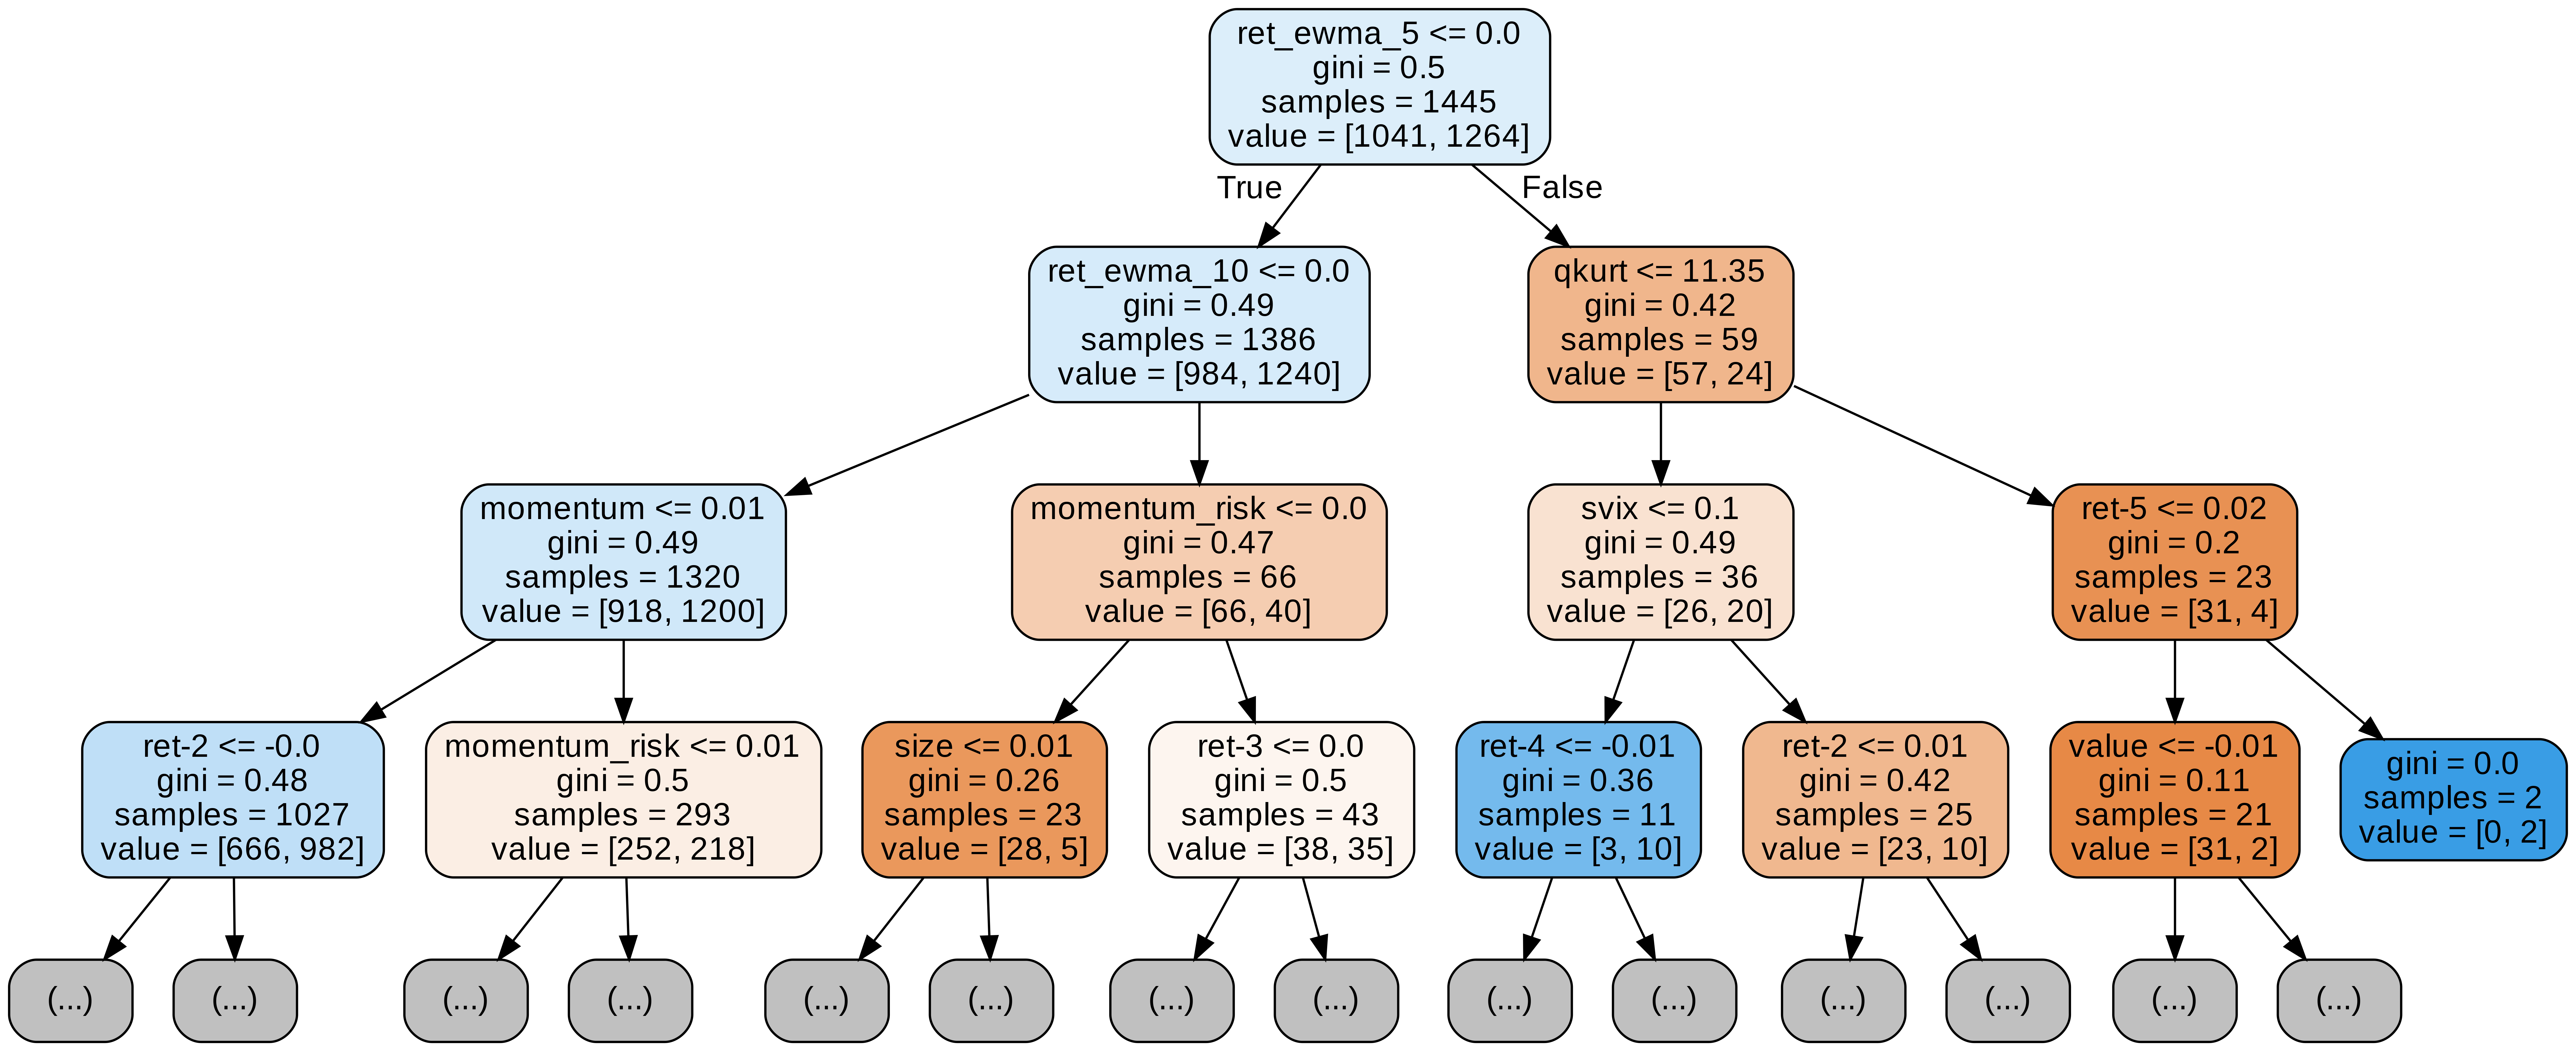

In [ ]:
# Extract single tree
singletree = model_randomforest_allData.estimators_[1]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(singletree,  out_file='tree.dot', max_depth = 3,
                feature_names = X_all_train.columns.values,class_names = None,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image, HTML
Image(filename = 'tree.png')

In this code, a single tree is extracted from a random forest model and visualized as a decision tree. This code illustrates how the tree-based model makes predictions visually.

The code first retrieves one of the individual trees from the random forest model. A single tree is assigned to the variable "singletree".

The code then imports the "export_graphviz" function from the "sklearn.tree" module. As a plain text graph description language, this function exports the tree as a dot file.

A call to the "export_graphviz" function is then made, specifying the output file name ("tree.dot"), the maximum depth of the tree (in this case, 3), the names of the features used in the training data, and the names of the classes. Tree visualization can be customized using these parameters.

The code converts the dot file into a PNG image after exporting the tree as a dot file. It is necessary to install Graphviz, a graph visualization program, in order to perform this conversion.

The code displays the generated PNG image ("tree.png") in a Jupyter notebook by using the "Image" and "HTML" functions from the "IPython.display" module. This image illustrates how the decision tree structure makes predictions based on input data features.

This code extracts a single tree from a random forest model, exports it as a dot file, converts it to a PNG image, and displays the PNG image in a Jupyter notebook, allowing visual inspection of the tree's structure and decision-making process.

Check out what the root node of this decision tree did.

When ret_ewma_5  0, the decision tree asks if ret_ewma_5  is less than 0. Depending on the result, it either follows the true path or the false path.

Gini = 0.5: Gini is a metric that measures the purity of a node/leaf (more on that later).

The training data contains 1445 samples, so this value is set to 1445.

The value list tells you how many samples at a given node fall into each category. This tree was constructed using 2305 of our 3303 values.

Additionally, we can see that the split criteria sometimes have different thresholds and orders. It's perfectly normal to experience this. For instance, momentum_risk on the third layer, second from the right has '<=0.01' whilst the threshold for the second layer, second from the right has '<= 0.0'

The ability to visualize certain trees in this way seems exciting. It's hard, however, to grasp the entire forest at once. (See documentation for scikit-learn)


Criteria for determining feature importance and splitting

Our data is split based on certain thresholds, as we mentioned earlier. Here are some possible split criteria we can use to decide which feature does the best job in splitting the data:

The first. Impurity in Gini

A Gini impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it had been randomly labeled according to the dataset's class distribution.

The G function is equal to \sum_{i=1}^{C} p(i)*(1-(p(i)) 

C is the number of classes and p(i) is the probability of randomly selecting an element from class i. (2017) (Hastie et al.)

I would like to illustrate this further. The class distribution in the dataset is used to classify a datapoint. The dataset we choose is randomly selected, but just to illustrate the point, let's say we have a data set with six values. In this example, we classify as up /frac[3][6] and down /frac[3][6].

The Gini impurity is what increases the likelihood that we classify the datapoint incorrectly. In our example, it would be 0.5. Since we have fewer misclassifications, a lower Gini impurity is favorable.

There are some gini values in the second layer that are lower than those in the root node, so shouldn't they be a better seperator? The answer is no, since we calculated gini importance step by step with the remaining data set.

This example is for binary decisions. Numeric data are sorted from lowest to highest and averaged. Gini impurity is calculated by asking if a value is less than the average between adjacent values. As a threshold, the lowest impurity is selected.

Gini impurity features:

Our model can also be evaluated by Gini impurity. `model.feature_importances_` allows us to print each split criterion's weighted importance. The number of samples split is accounted for by this parameter.

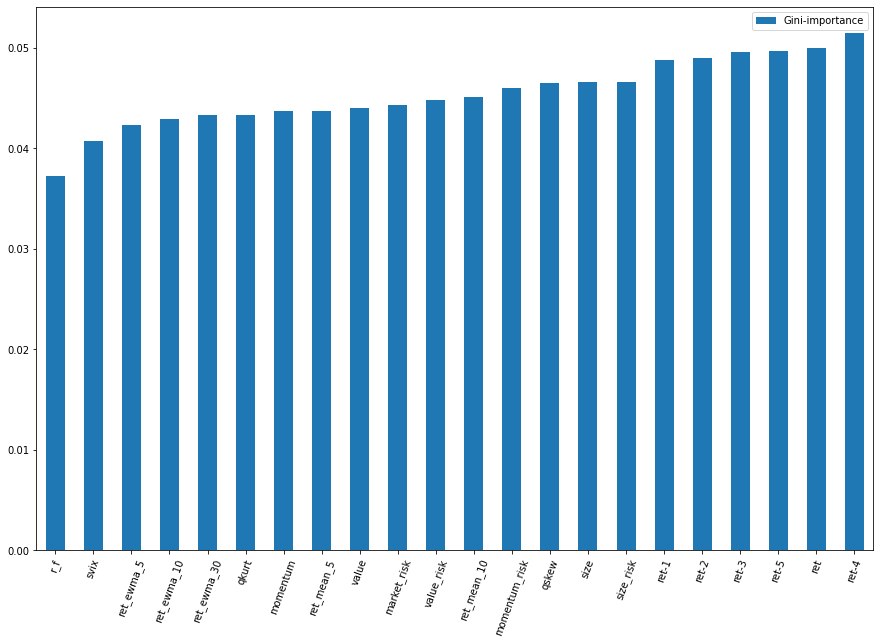

In [ ]:
%matplotlib inline

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_all_train.columns, model_randomforest_allData.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot= 70, figsize=(15,10), )

A random forest model's feature importances are computed and visualized using this code. Models are used to make predictions based on the relative importance of different features.

By using the "%matplotlib inline" command, the code sets up the environment for inline plotting. Jupyter notebooks will display the generated plots as a result.

To store feature names and their corresponding importances, the code initializes an empty dictionary called "feats.".

In the next step, the code iterates over the columns of the training data ("X_all_train.columns") and the feature importances of the random forest model ("model_randomforest_allData.feature_importances_"). By using the "zip" function, each feature is paired with its importance value and stored in the "feats" dictionary.

Next, the code creates a DataFrame called "importances" from the "feats" dictionary, orienting it so that the feature names are the index and renaming the column to "Gini-importance". Based on the random forest model, Gini-importance measures how much each feature contributes to impurity reduction.

As a final step, the code plots the feature importances as a bar chart using the "plot" function. The plot is set to have a vertical bar orientation ('kind='bar''), the x-axis labels are rotated by 70 degrees ('rot=70'), and the figure size is 15x10 inches ('figsize=(15,10)'). Plotting the relative importance of each feature allows easy comparison and identification of the most influential features in the random forest model.

This code calculates the feature importances of a random forest model and generates a bar chart to visualize the relative importance of each feature. Identifying the key features that affect the model's performance can be done with this information.

The return four days prior provides the best information about the split in this example. Return free rate is the worst job.

In other cases, we suggest looking at the feature importance to eliminate variables that explain very little of your classification. We can't really see any benefits from this analysis in this example.

Additionally, it is important to look for correlated features since one will appear less important than another. Due to the first feature, the impurity of the second feature has already been removed.

The second is. The Entopy is: 

Information gain can also be determined using entopy. In science, it is known as a measure of disorder.

It is equal to \sum_{i=1}^{C} -p(i)*log(p(i)) 

P(i) is the probability of randomly selecting an element from class i, where C is the number of classes. (2017) (Hastie et al.)

It can be interpreted that entopy values near 0 are pure, while values approaching 1 (sometimes above) are impure.

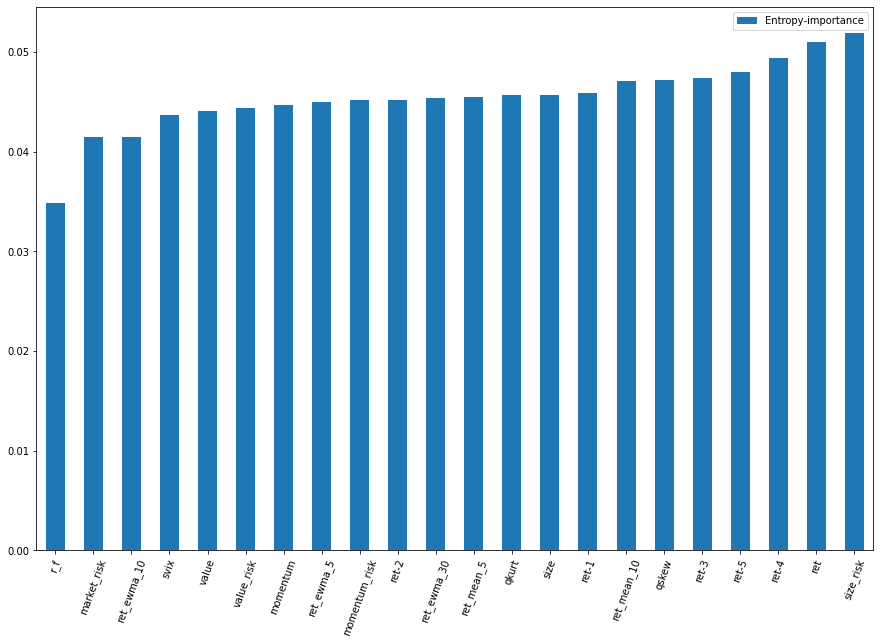

In [ ]:
%matplotlib inline

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_all_train.columns, model_randomforest_allData.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Entropy-importance'})
importances.sort_values(by='Entropy-importance').plot(kind='bar', rot= 70, figsize=(15,10), )

Using the "Entropy" criterion, this code calculates and visualizes the importance of features in a random forest model. A model based on impurity entropy is used to determine the relative importance of different features in making predictions.

"%matplotlib inline" is used to set up the environment for inline plotting. The generated plots are displayed within Jupyter notebooks as a result.

To store the feature names and their corresponding importance values, the code initializes an empty dictionary called "feats".

As a next step, the code iterates over the columns of the training data ("X_all_train.columns") and the feature importances of the random forest model ("model_randomforest_allData.feature_importances_"). Using the "zip" function, each feature is paired with its importance value and stored in the "features" dictionary.

Using the "feats" dictionary, the code creates a DataFrame called "importances" with the feature names as the index. In the DataFrame, the column is renamed "Entropy-importance" to indicate that the importances are calculated using entropy.

As a final step, the code plots the feature importances as a bar chart using the "plot" function from the "importances" DataFrame. The plot is set to have a vertical bar orientation ('kind='bar''), the x-axis labels are rotated 70 degrees ('rot=70'), and the figure size is set to 15x10 inches ('figsize=(15,10)'). Based on the entropy measure of impurity, the resulting plot illustrates the relative importance of certain features in the random forest model.

This code calculates the features' importances in a random forest model using the entropy criterion and generates a bar chart to visualize the relative importance of each feature. When considering entropy-based impurities, this information can help identify the key features that are most influential.

There are no noteworthy results compared to "Gini-Importance". All features are ranked equally important. It is also important to look for correlations between features.

The third point. Importance of permutations

The accuracy of the model can also be directly measured when selecting features. The idea is to permute the values of each feature and measure how much accuracy the permutation decreases. In the case of unimportant features, the accuracy would not change, while in the case of important features, the accuracy should change significantly (see the scikit-learn documentation).

Let's examine our model using scikit-learn's permutation_importance() method.

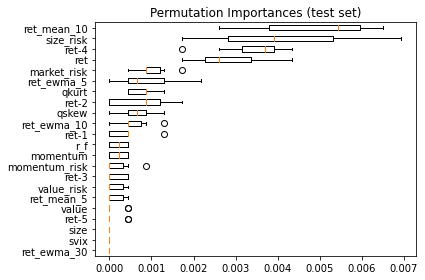

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(model_randomforest_allData,X_all_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels= X_all_train.columns[sorted_idx])
ax.set_title("Permutation Importances in our test set")
fig.tight_layout()
plt.show()

Random forest model permutation importances are analyzed using this code. We evaluate the model's performance after randomly permuting the values of each feature to determine the importance of each feature in making predictions.

The code imports the "permutation_importance" function from "sklearn.inspection". Calculate the importance of permutations using this function.

Afterwards, the function "permutation_importance" is called with the random forest model ("model_randomforest_allData"), the training data ("X_all_train"), the target variable ("y_train"), and additional parameters, such as the number of repetitions for permutation ("n_repeats"), the reproducibility state ("random_state"), and the number of parallel jobs ("-n_jobs=2").

Results of the permutation importances analysis are stored in the "result" variable, which contains information such as the importances for each feature and their mean.

Using "result.importances_mean", the code sorts the features based on their mean importance. The "sorted_idx" variable contains the indices of the sorted features.

Using the "subplots" function, the code creates a figure and axes object. Permutation importances will be plotted using this boxplot.

A boxplot is created using "boxplot" applied to "result.importances[sorted_idx].T", where the importances of the sorted features are transposed. Boxplots are displayed horizontally ("vert=False"), and feature labels are set as sorted feature names from "X_all_train.columns[sorted_idx]".

With the "set_title" method of the axes object, the plot's title is set to "Permutation Importances in our test set.".

A tight layout is achieved by using the "tight_layout" method, and the plot is displayed using the "show" function from the "matplotlib.pyplot" module.

This code performs a permutation importance analysis on a random forest model and generates a boxplot to visualize the relative importance of each feature. By evaluating the effect of random permutations on feature values, this analysis evaluates the impact of individual features on model performance.

Changing the above features does not significantly improve performance. We saw a 0.005 percent decrease in accuracy after permuting 'ret_mean_10.

The model will still have access to the feature through its correlated feature if two features are correlated and one is permuted. As a result, it will seem less important.

Before tuning, here are the big results:

To build our trees, we draw random subsets. We cannot guarantee the accuracy of our models. To obtain a normal distribution, we choose a sample size of thirty.

In [ ]:
scorelist = []

for i in range(30):
  model_randomforest_allData= RandomForestClassifier(n_estimators=100, oob_score=True)
  model_randomforest_allData.fit(X_all_train, y_train)
  y_predicted = model_randomforest_allData.predict(X_all_test)
  scorelist.append(accuracy_score(y_test, y_predicted))

The code trains and tests a random forest classifier model multiple times in order to evaluate its performance repeatedly. To assess the model's average performance over multiple iterations, accuracy scores are obtained.

To store the accuracy scores, an empty list called "scorelist" is created.

Using range(30), a loop is set up to iterate 30 times. Each iteration of this loop will repeat the following steps:

Within the loop, 100 decision trees are used to create a random forest classifier model. - The new model is trained using the training data "X_all_train" as well as the target labels "y_train". After training, the model is used to predict the target labels for the test data "X_all_test", which are stored in the "y_predicted" variable. By comparing the predicted labels "y_predicted" to Labels "y_test" are calculated using the accuracy_score function from the appropriate library. - The accuracy score is appended to the "scorelist" using the append method.

As a result of the loop, the "scorelist" contains 30 accuracy scores, each corresponding to a different iteration of training and testing.

This code trains and tests a random forest classifier model multiple times, storing the accuracy scores for each iteration. A model's average performance across multiple runs can be evaluated, providing insights into its overall effectiveness at making accurate predictions.

Based on our previously split data sets, we get the following accuracy results with standard settings.

When bootstrap is set to True:

The dataset used is 25% quantile, 75% quantile, 99% quantile, OOB Score Mean | --------------------------------------------------------------------------------------------|all data | 0.513903 | 0.519312 | 0.5273 | 0.542356 | 0.516095 | | forward | 0.518706 | 0.524941 | 0.532861 | 0.538635 | 0.502892 | | backward | 0.56572 | 0.513313 | 0.520728 | 0.530677 | 0.520174 | factors | 0.514914 | 0.523627 Affect on income | 0.532609 | 0.540364 | 0.519928 | | returns | 0.498483 | 0.504719 | 0.511628 | 0.519555 | 0.511468 | | affect on profits | 0.507331 | 0.513785 | 0.519717 | 0.528231 | 0.51219

When bootstrapping is set to False (to see if bootstrapping has any effect)

Use dataset | 25% quantile | Mean | 75% quantile | 99% quantile | OOB Score Mean |--------------------------------------------------------- | all data | 0.50758 | 0.506505 | 0.513145 | 0.525197 | - | | forward | 0.51997 | 0.523323 | 0.526542 | 0.530839 | - | | backward | 0.500253 | 0.512808 | 0.523003 | 0.530839 | - | factors | 0.515672 | 0.5212 The returns are 0.426795 | 0.537037 | - | | pca is 0.506279     | 0.50455     | 0.513212 | 0.520728       | 0.537462     | -       |

The results were not significantly better with a non-boostrapped data set. We also did not see any predictive results when we trained on various subsets of our features. Using reverse feature elimination based on non-correlated features and importances did not change this. Are there any ways to improve our results further?

Time series split with Gridseach crossvalidation for hyperparameter tuning

Using a random selection of variables (features), Decision Trees are created. The number of trees can also be selected. Here, we will examine how modifying these parameters will affect accuracy.

To obtain comparable results, we will also use TimeSeriesSplit Cross Validation.

Let's see what parameters are currently set. We can print out the currently used parameters using the method get_params().

In [ ]:
pprint(model_randomforest_allData.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


A random forest classifier model's parameters and their corresponding values are displayed in this code. The goal is to provide visibility into the configuration and settings of the model that have been specified or determined automatically.

On the "model_randomforest_allData" object, the "get_params()" method is called. A random forest classifier model's current parameter settings can be obtained using this method.

To make the parameters and their values more readable, the "pprint" function is used. 'Pprint' stands for "pretty print" and formats complex data structures, such as dictionaries and objects, visually.

Upon executing this code, the user can inspect the model's parameters and understand the specific settings used. The information provides insight into the model's behavior, any customization or tuning performed, and factors that may affect its performance.

It can be quite overwhelming to deal with this. The Scikit-Learn documentation says that the most important settings are n_estimators and max_features. When looking for the best split, these points indicate the number of trees in a forest and the number of features to consider. For every problem, it is difficult to determine the best parameters. We're trying out a variety of settings to see what works. In the same way as we did with the SVM, we will create a Parameter grid for this.

In [ ]:
# Number of trees in random forest, here we are creating 10 samples from the range of 200 to 2000
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
              # 'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
              # 'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

A random forest model is defined by this code. For hyperparameter tuning or model selection, a set of parameter combinations will be created.

This code defines the parameter "n_estimators", which represents the number of trees in the random forest. Using "np.linspace", it creates a list of 10 values evenly spaced between 200 and 2000. The number of trees will be determined by sampling these values.

In the decision tree, "max_features" specifies how many features should be considered at each split. There are two options: 'auto' and 'sqrt'. 'Auto' means that the model will consider all features, and 'sqrt' means that it will consider the square root of all features.

Other parameters, such as "max_depth", "min_samples_split", and "min_samples_leaf", are also commented out. The parameters control the depth of the tree, the number of samples required to split a node, and the number of samples required at each leaf node. Currently, these parameters are not used in the grid and are commented out.

When building trees, the parameter "bootstrap" determines whether bootstrap samples are used. The option is set to True or False, indicating whether bootstrap sampling should be performed.

The code creates a grid based on the parameters defined in the "param_grid_randomforest" dictionary. In hyperparameter tuning or model selection, this grid represents all possible combinations of parameter values.

This code specifies the number of trees, the number of features to consider, and the bootstrap sampling used for a random forest model. Using this grid, we will find the best combination of parameters to optimize the model's performance.

Each iteration of the algorithm will choose a different setting. With all options enabled, we are trying 10 * 2 * 12 * 3 * 3 * 2 = 4320 settings. It can become computationally very expensive if we have a large number of features. To begin with, we chose 40 settings and our "forward" dataset. Trying out all settings did not improve results in our testing.

In [ ]:
model_randomforest_gsearch= RandomForestClassifier()
#create GridSearch that uses all cores with set param grid
gsearch_randomforest = GridSearchCV(estimator=model_randomforest_gsearch, cv=tscv, param_grid=param_grid_randomforest, n_jobs = -1, verbose = 1)
#fit grid search
gsearch_randomforest.fit(X_forward_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 13.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_scor

To find the best hyperparameters for a random forest classifier model, this code performs a grid search with cross-validation. We aim to systematically explore different hyperparameter combinations and determine the optimal configuration.

A random forest classifier model called "model_randomforest_gsearch" is created first.

The GridSearchCV class is then used to set up the grid search. During the grid search, all available cores will be used for parallel processing ("-n_jobs = -1"), and verbose output will be provided ("-verbose = 1). In the grid search, "model_randomforest_gsearch" is specified as the estimator to be evaluated, and "param_grid_randomforest" is specified as the parameter grid. Different combinations of hyperparameter values are contained in "param_grid_randomforest".

Afterward, the code fits the grid search to the training data "X_forward_train" and the corresponding target labels "y_train". A grid search performs cross-validation, splitting the data into multiple folds and evaluating the model's performance on each fold based on different combinations of hyperparameters.

Grid search involves training and evaluating the model multiple times with different hyperparameter combinations. A cross-validation technique is used to assess the performance of each combination. Using the evaluation metric, the grid search identifies the combination of hyperparameters that yields the highest performance.

The code performs a grid search with cross-validation to identify the optimal hyperparameters for a random forest classifier. Using cross-validation, it explores different hyperparameter combinations and identifies the best configuration.

Regression analysis

Unbalanced class weights

Data in its entirety

<ul>           <ul>         <li>We use the open source library sklearn to implement our machine learning algorithm because it offers many useful functions and is relatively easy to get started with         </li>         <li>In order to get more informations about our coefficients and the significance of our independent variables we are also using the statsmodels library because sklearn does not offer the possibility to get them         </li>         <li>We implement an emty list model_list and the variable model_counter to save our Models and use them lateron         </li>         <li>We define logit_model as our statsmodels logistic regression model to fit a model using maximum likelihood estimations from the method Logit wich we pass our earlier defined y and X Dataframes         </li>         <li> results_sns saves the fited model from statsmodels so we can print out a summary for all our coefficients         </li>         <li>Next we define logreg as our logistic regression It is well suited for one against the rest situations and delivers a good runtime for large dataset regressions when using the 'liblinear' solver from Sklearn. (2008))
        </li>
        <li>We save the fited model in our model_list therefore we pass the method our X and y Dataframes
        </li>
        <li>y_pred saves the predicted values from our fited model on the X test set to print out a confusion matrix lateron
        </li>
        <li>The score method gives us the accuracy of our fited model on the unseen test data
        </li>
        </ul>
  </ul>

In [ ]:
model_counter = 0
model_list = [None] * 16

minmaxscaler.fit(X_all)
X_all_scaled = minmaxscaler.transform(X_all)
X_all_scaled = pd.DataFrame(X_all_scaled)
X_all_scaled.columns = X_all.columns.to_list()
y_logit = pd.DataFrame(y_logit)
y_logit.reset_index(inplace = True) 
y_logit = y_logit.ret_dir_logit


logit_model=sm.Logit(y_logit, X_all_scaled)
result_sns=logit_model.fit()
print(result_sns.summary())

logreg = LogisticRegression(solver='liblinear', max_iter=1000)
model_list[model_counter] = logreg.fit(X_all_scaled_train, y_train)
y_pred = logreg.predict(X_all_scaled_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_all_scaled_test, y_test)))

Optimization terminated successfully.
         Current function value: 0.684820
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3272
Method:                           MLE   Df Model:                           21
Date:                Mon, 25 May 2020   Pseudo R-squ.:                0.006295
Time:                        11:52:50   Log-Likelihood:                -2255.8
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                    0.1244
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ret              -1.1674      1.318     -0.885      0.376      -3.752       1.417
r_f               0.

A dataset is modeled using logistic regression in this code. We will build a logistic regression model, evaluate its performance, and print the results.

Initializing variables is the first step in the code. Model_counter is set to 0 and model_list is created as a 16-item list.

Using a min-max scaler, the code applies feature scaling to the input data "X_all". "X_all" is fit with the scaler, and then "X_all" is transformed and stored in "X_all_scaled". As soon as the transformed data is converted to a DataFrame, the column names are set to match the original "X_all" columns.

Modeling is prepared for the target variable "y_logit". The index is reset and it is converted to a DataFrame. Furthermore, the variable "y_logit" is further processed as needed (e.g., applying a particular transformation or taking the logarithm), and the resulting variable is assigned to "y_logit".

Statsmodels' "sm.Logit" class is used to create a logistic regression model. As inputs to the model, we use the target variable "y_logit" and the scaled input data "X_all_scaled". "Fit" is used to fit the logistic regression model to the data, and the result is stored in "result_sns".

"print(result_sns.summary())" prints the summary of the fitted logistic regression model. Information about the model's coefficients, statistical significance, and goodness of fit are presented in this summary.

The "LogisticRegression" class from the scikit-learn library is also used to create a logistic regression model. Fitting of this model is based on the training data "X_all_scaled_train" and the corresponding target labels "y_train". A model is stored in the "model_list" at the specified index "model_counter".

The logistic regression model is then used to predict the test data "X_all_scaled_test", and the predicted labels are stored in "y_pred".

The "print" statement prints the accuracy of the logistic regression classifier on the test set. A logistic regression model's "score" method is used to calculate the accuracy score.

This code performs logistic regression modeling on a dataset. The model scales the input features, prepares the target variable, fits a logistic regression model using both statsmodels and scikit-learn libraries, makes predictions, and prints the model's summary and accuracy score.

  Our logistic regression model determines after five iterations, as can be seen from the summary. Based on the Log-Likelihood for our model and the Log-Likelihood of the null hypothesis, we can see that our model does not improve value prediction. Because the Log-Likelihood Ratio p-value does not reach the 5% margin of significance, we should not reject the null hypothesis (see Hastie et al.). The statsmodels Logit model calculated the /beta values and standard errors for all our independent variables in the list (2017). The standard error is the square root of the diagonal of the covariance matrix for the coefficients. The z value can be calculated as follows: z = /frac[coef][std / err] Some literature recommends a z value bigger than 2 or smaller than -2 to say that the variable brings enough To hold them (see Hastie et al. (2017)) We can see that none of our independent variables reaches this limit, and we can interpret the p-values in such a way as not to reject the null hypothesis (Hastie et al., 2017). (2017)) As expected, we have an extremely poorly functioning model with an accuracy of 52% on our test data set

Using sklearn's cross_val_score method, we calculate the cross validation score for our earlier developed times series split method (tscv) for our X and Y train datasets.


In [ ]:
results = cross_val_score(logreg, X_all_scaled_train, y_train, cv=tscv, scoring='accuracy')
print("\n Time Series Split cross validation average accuracy: %.2f" % (results.mean()))


 Time Series Split cross validation average accuracy: 0.55


A logistic regression model is evaluated using time series split cross-validation. Using a cross-validation technique designed specifically for time series data, we assess the model's performance.

Scikit-learn's "cross_val_score" function is used in this code. Inputs include the logistic regression model "logreg", the training data "X_all_scaled_train", and the corresponding target labels "y_train". "cv" is set to "tscv", which represents the time series cross-validator that defines the splitting strategy. To evaluate the model's accuracy, the "scoring" parameter is set to 'accuracy'.

By splitting the time series data into multiple folds, the "cross_val_score" function performs cross-validation. The logistic regression model is trained on the training data and evaluated on the validation data using accuracy as the evaluation metric. For each fold, the function returns an array of accuracy scores.

By applying the "mean" method to the array of accuracy scores, the code prints the average accuracy of the logistic regression model across all folds. Based on the cross-validation results, the average accuracy represents the overall performance of the model.

A logistic regression model is assessed using time series split cross-validation. Time series data are split into folds, the model is trained and evaluated on each fold, and the average accuracy is calculated. On unseen time series data, this provides an estimation of the model's generalization performance.

There is a slight improvement, but it is not significant


To get a better understanding of how our model makes predictions we want to look at the confusion matrix for our y test dataset. Therefore, we are using the confusion matrix method from Sklearn and passing it the predicted and actual values.


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  7 461]
 [ 12 509]]


Based on the predicted labels generated by a model and the true labels from the test set, this code calculates and prints the confusion matrix. In order to evaluate the model's performance, we examine the number of correct and incorrect predictions for each class.

An appropriate library's "confusion_matrix" function is used in the code. Inputs are the true labels "y_test" and the predicted labels "y_pred".

"Confusion_matrix" computes a matrix that summarizes the model's predictions. A row in the matrix represents the true labels of a specific class, whereas a column represents the predicted labels. Matrix elements count the number of observations that fall into each of the true and predicted labels.

Using the "print" statement, the confusion matrix is printed. It displays the number of true positives, true negatives, false positives, and false negatives for each class of the model.

The confusion matrix summarizes the performance of a model by showing the number of correct and incorrect predictions for each class. Confusion matrices can be used to evaluate the model's accuracy and to identify any patterns of misclassification.

Almost every falling return is predicted as rising in our model, as expected. Our method classification_report gives an overview of our model by calculating its precision, recall and f1 score on the test data. The recall is simply how likely the estimator is to find all positive samples for both results. F1 is the harmonic mean of precision and recall. Test data support is the number of rising and falling results.

In [ ]:
print('\n' + classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        -1.0       0.37      0.01      0.03       468
         1.0       0.52      0.98      0.68       521

    accuracy                           0.52       989
   macro avg       0.45      0.50      0.36       989
weighted avg       0.45      0.52      0.37       989



Based on a model's predicted labels and the test set's true labels, this code prints a classification report. A comprehensive evaluation of the model's performance is provided, including precision, recall, F1-score, and support for each class.

From a relevant library, the code uses the "classification_report" function. Inputs are the true labels "y_test" and predicted labels "y_pred".

A report summarizing each class's performance metrics is generated by the "classification_report" function. Metrics such as precision, recall, and F1-score are included in the report. Among all positive predictions for a given class, precision measures the proportion of true positive predictions. Based on all actual positive instances, recall calculates the proportion of true positive predictions. An F1-score measures the model's accuracy by balancing precision and recall. Support represents the number of instances of each class in the test data.

Using the "print" statement, the code prints the classification report. It includes the aforementioned metrics for each class, as well as an overall average of the model's performance.

Essentially, this code generates and displays the classification report, which provides metrics such as precision, recall, F1-score, and support for each class in the test data. Classification reports are useful for assessing the model's accuracy, identifying areas for improvement, and understanding its performance.

It is also important to measure performance in multiclass classification using the Receiver Operating Characteristics (ROC) Area Under the Curve (AUC) curve (see Bradley (1996)). In order to visualize our curve, we will use a matplotlib plot to visualize our y_test set and our predicted values for our x_test set. We will also initialize a variable summary_counter and a list summary in order to get a summary of all our tries at the end of this chapter. For this estimator, we will store our results

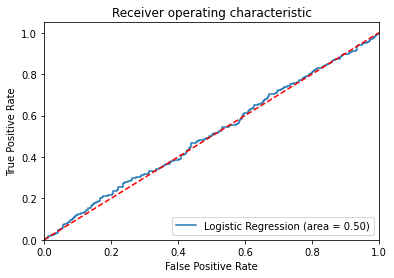

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_all_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_all_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary_counter = 0
summary = [None] * 16
summary[summary_counter] = ('All data unbalanced classweights:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_all_scaled_test, y_test)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_test, y_pred) +
                            '\n AOC score: %0.2f' % roc_auc_score(y_test, logreg.predict(X_all_scaled_test))
                           )
summary_counter+=1

The code generates a summary list of the evaluation results for a logistic regression model. ROC curves are also created and displayed for the model's performance.

By using the "roc_auc_score" function, the code calculates the area under the ROC curve (ROC AUC score). Using predicted probabilities, this score quantifies the model's ability to distinguish between positive and negative classes.

The "roc_curve" function is then used to calculate the false positive rate (FPR), true positive rate (TPR), and thresholds. To visualize the trade-off between the true positive rate and false positive rate, the ROC curve is plotted using these values.

By using the "plt.plot" function, the code creates a figure and plots the ROC curve. ROC AUC is included in the plot's label. The random classifier is also represented by a dashed red line.

Plot configurations include setting the x-axis and y-axis limits, labeling the axes, setting the title, and adding a legend.

ROC curve plots are saved as images using the "plt.savefig" function, and displayed using "plt.show".

The evaluation results are then summarized. In this code, a summary list and a summary counter are initialized. As part of the summary information, you will find the counter for the model list, a summary of the logistic regression model, the model's accuracy on the test set, the average accuracy from time series split cross-validation, the classification report, and the ROC AUC. Labels and formatting are concatenated with these details.

A summary is stored in the summary list at the specified index indicated by the summary counter. In subsequent iterations, the summary counter is incremented.

The code generates an ROC curve and calculates the ROC AUC score for a logistic regression model. A summary list is also created of the model's evaluation results. Various metrics and reports provide insight into the performance of the model in the summary.

The AUC value shows how well the model can distinguish between classes. In plain English: the higher the AUC value, the better it is at classifying rising or falling returns. In the ROC curve, the true positive rate (TPR) is plotted against the false positive rate (FPR), with the TPR axis being on the y-axis and the FPR on the x-axis. In the Legend, Logistic Regression (area=0.50) indicates a 0.50 AUC. As mentioned above, we can also rely on a coin tos Calculate the return on investment

The forward-looking data As we have seen above, none of our features have achieved the desired significance, so we carry out an emotional feature selection and then test the forward-looking feature as with the other two algorithms. We run the same code as above, but this time we are using a smaller X dataset (X_forward_scaled).


Optimization terminated successfully.
         Current function value: 0.688627
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            3
Date:                Mon, 25 May 2020   Pseudo R-squ.:               0.0007719
Time:                        11:53:02   Log-Likelihood:                -2268.3
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                    0.3202
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
r_f            0.1012      0.114      0.889      0.374      -0.122       0.324
svix          -0.2520      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


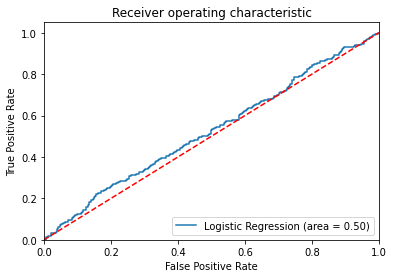

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
minmaxscaler.fit(X_forward)
X_forward_scaled = minmaxscaler.transform(X_forward)
X_forward_scaled = pd.DataFrame(X_forward_scaled)
X_forward_scaled.columns = X_forward.columns.to_list()

logit_model=sm.Logit(y_logit, X_forward_scaled, maxiter=50)
result_sns=logit_model.fit()
print(result_sns.summary())

logreg.fit(X_forward_scaled_train, y_train)

y_pred = logreg.predict(X_forward_scaled_test)
print('\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_forward_scaled_test, y_test)))

results = cross_val_score(logreg, X_forward_scaled_train, y_train, cv=tscv, scoring='accuracy')
print('\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()))

cm = confusion_matrix(y_test, y_pred)
print()
print(cm)

print('\n Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_forward_scaled_test, y_test)))
print('\n' + classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_forward_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_forward_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary[summary_counter] = (' Forward looking data unbalanced classweights:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_forward_scaled_test, y_test)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_test, y_pred) +
                            '\n AOC score: %0.2f' % roc_auc_score(y_test, logreg.predict(X_forward_scaled_test))
                           )
summary_counter+=1

On a forward-looking dataset, this code applies logistic regression modeling. Using the forward-looking data, we will build a logistic regression model, evaluate its performance, and store the evaluation results.

Using a min-max scaler, the code applies feature scaling to the input features "X_forward". A scaler is fitted to "X_forward" to learn the scaling parameters, and then "X_forward" is transformed into "X_forward_scaled". We convert the transformed data into a DataFrame and set the column names to match the original "X_forward" columns.

In the statsmodels library, the "sm.Logit" class is used to create a logistic regression model. Model inputs include the target variable "y_logit" and the scaled input data "X_forward_scaled". For convergence, 50 iterations are allowed. Using the "fit" method, the logistic regression model is fitted to the data, and the results are saved in "result_sns".

"print(result_sns.summary())" prints the summary of the fitted logistic regression model. An overview of the model's coefficients, statistical significance, and goodness of fit can be found here.

Using the training data "X_forward_scaled_train" and the corresponding target labels "y_train", a logistic regression model is fitted from scikit-learn. A model is stored in the "model_list" at the specified index "model_counter".

A logistic regression model is then used to predict the test data "X_forward_scaled_test", and the predicted labels are stored in "y_pred".

"print" prints the accuracy of the logistic regression classifier on the test set. A logistic regression model's "score" method is used to calculate the accuracy score.

Using the "cross_val_score" function, the logistic regression model is cross-validated. Using the specified time series splitting strategy "tscv", it uses the training data "X_forward_scaled_train" and the target labels "Y_train". Each fold is scored, and the average accuracy across all folds is displayed.

Using the predicted labels "y_pred" and the true labels "y_test", the confusion matrix is calculated. In the confusion matrix, the number of true positives, true negatives, false positives, and false negatives for each class is shown.

It is possible to print and display the accuracy, classification report, and ROC curve plot with the corresponding AUC score by using the "print" and "plt" functions.

In the summary list, the evaluation results are summarized. Concatenated with relevant labels and formatting are the counter for the model list and summary information, including the logistic regression model summary, accuracy, cross-validation average accuracy, classification report, and AUC score. A summary is stored in the summary list at the index indicated by the summary counter. In subsequent iterations, the summary counter is incremented.

This code performs logistic regression modeling on forward-looking data. The model fits a logistic regression model using both statsmodels and scikit-learn libraries, makes predictions, and evaluates its performance using accuracy, cross-validation, confusion matrix, classification report, and ROC curve analysis. For further analysis and comparison, evaluation results are stored in a summary list.

It is again the LLR p-value that leads us to accept the null hypothesis rather than our model, but this time the qskew z value reached a significance margin of 2 and its p-value was smaller than 0.05, so we should conclude that the Feature and its coefficient contribute to the model and improve its performance.

We can see that there is still no real classification going on when we review the Accuracy on the test set, the time series cross validation score, and the confusion matrix again. For every observation in the test data, our model predicts a rising return. However, the ROC curve does not show any improvement in total.


Backward looking data Just to test if there is any improvement we try our backward looking data too. We run the same code but this time we use X_backward_scaled.


Optimization terminated successfully.
         Current function value: 0.685202
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3276
Method:                           MLE   Df Model:                           17
Date:                Mon, 25 May 2020   Pseudo R-squ.:                0.005741
Time:                        11:53:05   Log-Likelihood:                -2257.1
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                   0.07326
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ret              -0.8576      1.273     -0.674      0.500      -3.352       1.637
market_risk      -0.

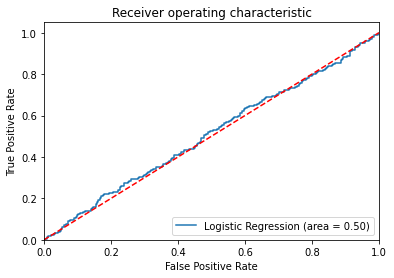

In [ ]:
minmaxscaler.fit(X_backward)
X_backward_scaled = minmaxscaler.transform(X_backward)
X_backward_scaled = pd.DataFrame(X_backward_scaled)
X_backward_scaled.columns = X_backward.columns.to_list()

logit_model=sm.Logit(y_logit, X_backward_scaled, maxiter=50)
result_sns=logit_model.fit()
print(result_sns.summary())

logreg.fit(X_backward_scaled_train, y_train)

y_pred = logreg.predict(X_backward_scaled_test)
print('\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_backward_scaled_test, y_test)))

results = cross_val_score(logreg, X_backward_scaled_train, y_train, cv=tscv, scoring='accuracy')
print('\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()))

cm = confusion_matrix(y_test, y_pred)
print()
print(cm)

print('\n Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_backward_scaled_test, y_test)))
print('\n' + classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_backward_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_backward_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary[summary_counter] = (' Backward looking data unbalanced classweights:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_backward_scaled_test, y_test)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_test, y_pred) +
                            '\n AOC score: %0.2f' % roc_auc_score(y_test, logreg.predict(X_backward_scaled_test))
                           )
summary_counter+=1

On backward-looking data, this code applies logistic regression modeling. We are building a logistic regression model based on backward-looking data, evaluating its performance, and storing the results in a summary table.

A min-max scaler is used to apply feature scaling to the input features "X_backward". A scaler is fitted to "X_backward" to learn the scaling parameters, and then "X_backward" is transformed into "X_backward_scaled". Column names are set to match the original "X_backward" columns in the transformed data frame.

Using the statsmodels library's "sm.Logit" class, a logistic regression model is created. Inputs to the model include the target variable "y_logit" and the scaled input data "X_backward_scaled". For convergence, 50 iterations are allowed. Using the "fit" method, the logistic regression model is fitted to the data, and the result is stored in "result_sns".

A summary of the fitted logistic regression model is printed using the "print(result_sns.summary())" statement. The summary provides information about the model's coefficients, statistical significance, and goodness of fit.

Using the training data "X_backward_scaled_train" and the target labels "y_train", a logistic regression model is fitted using scikit-learn. A model is stored in the "model_list" at the specified index "model_counter".

A logistic regression model is then used to predict labels for the test data "X_backward_scaled_test", and the predicted labels are stored in "y_pred".

The "print" statement displays the accuracy of the logistic regression classifier on the test set. A logistic regression model's "score" method is used to calculate accuracy scores.

The "cross_val_score" function is used to cross-validate the logistic regression model. With the specified time series splitting strategy "tscv", it uses the training data "X_backward_scaled_train" and the corresponding target labels "Y_train". Each fold is scored, and the average accuracy across all folds is displayed.

Using the predicted labels "y_pred" and the true labels "y_test", the confusion matrix is calculated. A confusion matrix shows the number of true positives, true negatives, false positives, and false negatives for each class of the model.

By using the "print" and "plt" functions, accuracy, classification report, and ROC curve plot with corresponding AUC score can be printed and displayed.

In the summary list, the evaluation results are summarized. Concatenated with relevant labels and formatting are the counters for the model list and summary information, including the logistic regression model summary, accuracy, cross-validation average accuracy, classification report, and AUC score. Summary information is stored in the summary list at the index indicated by the summary counter. In subsequent iterations, the summary counter is incremented.

This code performs logistic regression modeling on backward-looking data. Using statsmodels and scikit-learn libraries, it scales input features, fits a logistic regression model, makes predictions, and evaluates the model's performance through accuracy, cross-validation, confusion matrix, classification report, and ROC curve analysis. For further analysis and comparison, the evaluation results are stored in a summary list.

As a result of the LLR p-value, we accept the null hypothesis rather than our model, but this time the ret-2 z value has reached a significance margin of 2 and its p-value is smaller than 0.05, so we can conclude that the model is improved by this feature and its coefficient.

According to the Accuracy score on the test set, the cross validation score for the time series, and the confusion matrix, there is still no real classification going on. This time, our model predicts a few observations falling, but not in a positive way. The ROC curves are very similar to the previous ones


Recursive feature elimination (RFE) By selecting the best features in the last two steps, we were able to improve our model. The model's performance can be improved by reducing features (Hastie et al. The year 2017)

In order to select the best features for our model, we can use Sklearn's Recursive Feature Elimination (RFE). Its purpose is to perform a feature ranking for a defined estimator (logreg) by fitting the model and dropping the least important feature by a coefficient or a feature importance attribute. This process is repeated until the remaining features are of a given feature importance or until a specific number of features is dropped. By default, the RFE method reduces all features to half of We implement the method as follows and print the selection from the RFE

In [ ]:
sel = RFE(logreg)
sel = sel.fit(X_all_scaled_train, y_train)
temp = sel.get_support().tolist()

for i in range(len(temp)):
    print(X_all_train.columns.tolist()[i]+ ' = '+ str(temp[i]))

ret = True
r_f = False
svix = True
qskew = True
qkurt = False
market_risk = True
size = True
size_risk = True
value = False
value_risk = False
momentum = False
momentum_risk = False
ret-1 = True
ret-2 = True
ret-3 = False
ret-4 = True
ret-5 = False
ret_mean_5 = True
ret_mean_10 = True
ret_ewma_5 = False
ret_ewma_10 = False
ret_ewma_30 = False


Using a logistic regression model, this code selects features using the Recursive Feature Elimination (RFE) method. A logistic regression model's predictive performance is determined by identifying its most important features.

This code initializes an RFE object called "sel" with the logistic regression model "logreg".

Using the "fit" method, the RFE object is fitted to the training data "X_all_scaled_train" and the corresponding target labels "y_train". Iteratively, less important features are eliminated based on their contribution to the model's performance.

A boolean mask indicating the selected features is returned by the "get_support" method of the RFE object. Using the "tolist" method, the boolean mask is converted to a list.

The list of selected features is then iterated over using a loop. The code prints the feature name and whether it is selected or not for each feature. Based on this statement, the logistic regression model can determine whether each feature is important or not.

For feature selection, this code applies Recursive Feature Elimination (RFE) with a logistic regression model. Fits the RFE object to the training data, identifies the selected features, and prints a statement indicating whether each feature is important or not. According to the RFE selection process, this helps determine which features are the most predictive.

We can see that the RFE selected qskew and ret-2 as we would have done from the results above. We will only select the features selected by the RFE and run our code again.


Optimization terminated successfully.
         Current function value: 0.686926
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3283
Method:                           MLE   Df Model:                           10
Date:                Mon, 25 May 2020   Pseudo R-squ.:                0.003240
Time:                        11:53:20   Log-Likelihood:                -2262.7
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                    0.1430
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ret            -7.0151      4.540     -1.545      0.122     -15.914       1.884
svix            3.2690    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


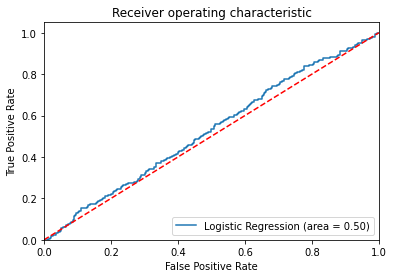

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
RFE_list = [None] * int((len(temp)/2))
z = 0 

for i in range(len(temp)):
    if str(temp[i]) == 'True':
        RFE_list[z] = X_all_train.columns[i]
        z+=1

X_RFE = df[RFE_list]
X_RFE.reset_index(inplace = True)
del X_RFE['loctimestamp']

X_trainRFE, X_testRFE, y_trainRFE, y_testRFE = train_test_split(X_RFE, y, test_size=0.3, random_state=None, shuffle=False)

logit_model=sm.Logit(y_logit, X_RFE, maxiter=50)
result_sns=logit_model.fit()
print(result_sns.summary())

logreg.fit(X_trainRFE, y_trainRFE)

y_predRFE = logreg.predict(X_testRFE)
print('\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_testRFE, y_testRFE)))

results = cross_val_score(logreg, X_trainRFE, y_trainRFE, cv=tscv, scoring='accuracy')
print('\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()))

cm = confusion_matrix(y_testRFE, y_predRFE)
print()
print(cm)

print('\n Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_testRFE, y_testRFE)))
print('\n' + classification_report(y_testRFE, y_predRFE))

logit_roc_auc = roc_auc_score(y_testRFE, logreg.predict(X_testRFE))
fpr, tpr, thresholds = roc_curve(y_testRFE, logreg.predict_proba(X_testRFE)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary[summary_counter] = (' Recursive feature elimination (RFE) unbalanced classweights:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_testRFE, y_testRFE)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_testRFE, y_predRFE) +
                            '\n AOC score: %0.2f' % roc_auc_score(y_test, logreg.predict(X_testRFE))
                           )
summary_counter+=1

Using Recursive Feature Elimination (RFE), this code selects features and applies logistic regression modeling to them. By using RFE, we identify important features, create a new dataset with only those features, and evaluate the logistic regression model on the reduced dataset.

To store the names of the selected features, the code creates an empty list called "RFE_list". To keep track of the index for adding features to "RFE_list", the variable "z" is set to 0.

To iterate over the "temp" list, which contains boolean values indicating whether each feature has been selected, a loop is used. "RFE_list" is incremented if a feature is selected (i.e., its boolean value is "True").

"X_RFE" is created by selecting the columns from "RFE_list" from the original dataset "df". "X_RFE"'s index is reset, and the "loctimestamp" column is removed.

"train_test_split" divides the dataset into training and test sets. In the training set, "X_trainRFE" and "y_trainRFE" are used, while in the test set, "X_testRFE" and "y_testRFE" are used. In order to maintain the time series order, 30% of the data is used in the test set, and the data is not shuffled.

The "sm.Logit" class from the statsmodels library is used to create a logistic regression model. Model inputs include the target variable "y_logit" and the reduced feature set "X_RFE". For convergence, 50 iterations are allowed. A logistic regression model is fitted to the data using the "fit" method, and the results are stored in "result_sns".

"print(result_sns.summary())" prints the summary of the fitted logistic regression model. It provides information about the model's coefficients, statistical significance, and goodness-of-fit measures.

Using the training data "X_trainRFE" and the corresponding target labels "y_trainRFE", a logistic regression model is fitted using scikit-learn.

The logistic regression model is used to predict the test data "X_testRFE", and the predicted labels are stored in "y_predRFE".

A print statement is used to display the accuracy of the logistic regression classifier on the test set. Based on the logistic regression model, the accuracy score is calculated using the "score" method.

The "cross_val_score" function is used to cross-validate the logistic regression model. Using the specified time series splitting strategy "tscv", it splits the training data "X_trainRFE" into target labels "y_trainRFE". Each fold's accuracy scores are computed, and the average accuracy is displayed.

Based on the predicted labels "y_predRFE" and the true labels "y_testRFE", the confusion matrix is calculated. This confusion matrix shows the number of true positives, true negatives, false positives, and false negatives for each class of the model.

"print" and "plt" are used to print and display the accuracy, classification report, and ROC curve plot with the corresponding AUC score.

In the summary list, the evaluation results are summarized. There is a concatenation of the model list counter, accuracy, cross-validation average accuracy, classification report, and AUC score, along with relevant labels and formatting. In the summary list, the summary is stored at the specified index

 Counter for summary. In subsequent iterations, the summary counter is incremented.

This code performs feature selection based on RFE, creates a new dataset with the selected features, applies logistic regression modeling to the reduced feature set, and evaluates the model. The evaluation results are printed and stored in a summary list, including the logistic regression model summary, accuracy, cross-validation average accuracy, classification report, and AUC. Using a reduced feature set, the model's predictive performance can be evaluated on the basis of the importance of selected features.


In this case, we accept the null hypothesis instead of our model because of the LLR p-value 

This time qskew and svix reach the predefined values at z and p
but they are the only ones and even ret-2 does not give any significant information to the model. We can see that we ended up in the same classification as we got using only forward looking data. The ROC curve appears somewhat better, but still very poor.


In [ ]:
X_pca_scaled = X_pca_scaled[['PC3', 'PC4', 'PC13']]

X_pca_scaled_train, X_pca_scaled_test = train_test_split(X_pca_scaled, shuffle= False, test_size=0.3)

logreg = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
logreg.fit(X_pca_scaled_train, y_train)

parameters = {"C":np.logspace(-5,15), "penalty":["l1","l2"]}

clf = GridSearchCV(logreg, parameters, cv=tscv, iid=False, n_jobs=-1, verbose=1)
clf.fit(X_returns_scaled_train, y_train)
print("\n Tuned hpyerparameters :(best parameters) ", clf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Tuned hpyerparameters :(best parameters)  {'C': 5.1794746792312125, 'penalty': 'l1'}


Logistic regression is performed on a dataset that has undergone principal component analysis (PCA) and feature selection. A logistic regression model will be built using the selected principal components, and hyperparameters will be tuned to optimize the model's performance.

Using the PCA-transformed and scaled dataset, the code selects specific principal components. The dataset only contains the principal components 'PC3', 'PC4', and 'PC13', which are stored in "X_pca_scaled".

Using the "train_test_split" function, the dataset is then divided into training and test sets. Training set "X_pca_scaled_train" and test set "X_pca_scaled_test" are created. To maintain the time series order, the data is not shuffled, and the test set size is set to 30%.

The solver, maximum number of iterations, and class weights of a logistic regression model are specified at the beginning. A model is fitted to the training data "X_pca_scaled_train" and "Y_train".

The "GridSearchCV" class is then used to tune the logistic regression model's hyperparameters. Grid search explores different combinations of hyperparameters, including regularization parameter "C" and penalty type ("l1" or "l2"). Using the training data and the corresponding target labels, "X_pca_scaled_train" and "Y_train", the grid search is performed using the time series splitting strategy "tscv".

With the "print" statement, the best hyperparameters are printed after the grid search is completed. According to the evaluation metric used in the grid search, the output displays the tuned hyperparameters that provide the best performance.

This code performs logistic regression on a PCA- and feature-selected dataset. By selecting specific principal components, splitting the data into training and test sets, fitting a logistic regression model, and tuning the hyperparameters, the model is tuned. Based on the evaluated performance, the best hyperparameters for the logistic regression model are printed.

Optimization terminated successfully.
         Current function value: 0.690674
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3291
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 May 2020   Pseudo R-squ.:               -0.002198
Time:                        15:21:00   Log-Likelihood:                -2275.1
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC3           -0.4850      0.255     -1.902      0.057      -0.985       0.015
PC4            1.2473      0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time Series Split cross validation average accuracy: 0.53

[[184 284]
 [187 334]]

              precision    recall  f1-score   support

        -1.0       0.50      0.39      0.44       468
         1.0       0.54      0.64      0.59       521

    accuracy                           0.52       989
   macro avg       0.52      0.52      0.51       989
weighted avg       0.52      0.52      0.52       989



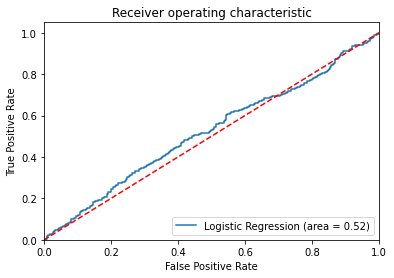

In [ ]:
logreg = clf.best_estimator_
model_counter+=1
model_list[model_counter] = logreg.fit(X_pca_scaled_train, y_train)

logit_model=sm.Logit(y_logit, X_pca_scaled, maxiter=50)
result_sns=logit_model.fit()
print(result_sns.summary())

y_pred = logreg.predict(X_pca_scaled_test)
print('\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_pca_scaled_test, y_test)))

results = cross_val_score(clf , X_pca_scaled_train, y_train, cv=tscv, scoring='accuracy')
print("\n Time Series Split cross validation average accuracy: %.2f" % (results.mean()))

cm = confusion_matrix(y_test, y_pred)
print()
print(cm)

print('\n' + classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_pca_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_pca_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary[summary_counter] = (' Reduced PCA with GridSearchCV balanced classweight:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_pca_scaled_test, y_test)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_test, y_pred) +
                            '\n AOC score: %0.2f' % logit_roc_auc)
summary_counter+=1

By using GridSearchCV for hyperparameter tuning, this code performs logistic regression on a reduced dataset obtained from PCA. Using the reduced principal components, we will build a logistic regression model and evaluate its performance.

"clf.best_estimator_" is used to access the best estimator from the grid search. A logistic regression model is fitted to the training data, "X_pca_scaled_train" and "Y_train". At the specified index, the fitted model is stored in the model list.

Using the "sm.Logit" class from the statsmodels library, a logistic regression model is created. As inputs, we use the target variable "y_logit" and the reduced feature set "X_pca_scaled". For convergence, 50 iterations are allowed. A logistic regression model is fitted to the data using the "fit" method, and the result is stored in "result_sns". "print(result_sns.summary())" prints the summary of the fitted logistic regression model.

The logistic regression model is used to predict the test data, "X_pca_scaled_test". In "y_pred", predicted labels are stored. The "print" statement prints the accuracy of the logistic regression classifier on the test set. A logistic regression model's "score" method is used to calculate the accuracy score.

Using the "cross_val_score" function, the logistic regression model is cross-validated. The training data "X_pca_scaled_train" and the target labels "y_train" are used with the specified time series splitting strategy "tscv". Each fold's accuracy score is calculated, and the average accuracy across all folds is displayed.

Using the predicted labels "y_pred" and the true labels "y_test", the confusion matrix is calculated. For each class, the confusion matrix displays the number of true positives, true negatives, false positives, and false negatives.

AUC scores are displayed along with the accuracy report, classification report, and ROC curve plot. For each class, the classification report provides precision, recall, F1-score, and support. With the "roc_auc_score" function, the area under the curve (AUC) score is calculated.

In the summary list, the evaluation results are summarized. Concatenated with relevant labels and formatting are the counters for the model list and summary information, including the logistic regression model summary, accuracy, cross-validation average accuracy, classification report, and AUC score. Using the summary counter, the summary is stored in the summary list at the specified index. In subsequent iterations, the summary counter is incremented.

Using GridSearchCV for hyperparameter tuning, this code performs logistic regression on a reduced dataset derived from PCA. The program fits the logistic regression model, evaluates its performance, and summarizes the results. Evaluation includes accuracy, cross-validation, confusion matrix, classification report, and ROC curve analysis. PCA and hyperparameter tuning provide insight into the performance of the logistic regression model on the reduced feature set.

In [ ]:
logit_model=sm.Logit(y_logit, X_all_scaled, maxiter=50)
result_sns=logit_model.fit()
print(result_sns.summary())

Optimization terminated successfully.
         Current function value: 0.687465
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3291
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 May 2020   Pseudo R-squ.:                0.002458
Time:                        15:21:09   Log-Likelihood:                -2264.5
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                  0.003771
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret-1          1.3758      0.570      2.413      0.016       0.258       2.493
ret-2          1.4896      0.

Using the statsmodels library, this code performs logistic regression. Logistic regression is used to fit a model to the dataset that has been scaled using the min-max scaler, "X_all_scaled", and the corresponding target variable, "y_logit".

"sm.Logit" is used to create the logistic regression model. Model inputs are the target variable, "y_logit", and the scaled feature set, "X_all_scaled". For convergence, 50 iterations are allowed.

A logistic regression model is fitted to the data using the "fit" method, and the result of the fitting process is stored in the "result_sns" variable. A summary of the logistic regression model's parameters, coefficients, statistical measures, and goodness-of-fit statistics is obtained by calling the "summary" method on "result_sns.".

Using the "print(result_sns.summary())" statement, the logistic regression model summary is printed. This provides a comprehensive overview of the model's performance, including coefficient estimates, standard errors, p-values, and various statistical measures.

Using the statsmodels library, this code performs logistic regression. A logistic regression model is fitted to the scaled dataset, "X_all_scaled", and the corresponding target variable, "y_logit". Detailed information about the parameters and statistical measures of the fitted model is then displayed in the summary.

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



 Tuned hpyerparameters :(best parameters)  {'C': 5.1794746792312125, 'penalty': 'l1'}
Accuracy of logistic regression classifier on test set: 0.51
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning



 Time Series Split cross validation average accuracy: 0.51
[[274 194]
 [289 232]]

              precision    recall  f1-score   support

        -1.0       0.49      0.59      0.53       468
         1.0       0.54      0.45      0.49       521

    accuracy                           0.51       989
   macro avg       0.52      0.52      0.51       989
weighted avg       0.52      0.51      0.51       989



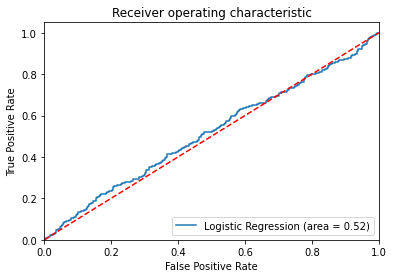

In [ ]:
X_all_scaled_train, X_all_scaled_test = train_test_split(X_all_scaled, shuffle = False, test_size = 0.3)

logreg = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')

logreg.fit(X_all_scaled_train, y_train)

parameters = {"C":np.logspace(-5,15), "penalty":["l1","l2"]}

clf = GridSearchCV(logreg, parameters, cv=tscv, iid=False, n_jobs=-1, verbose=1)
clf.fit(X_all_scaled_train, y_train)
print("\n Tuned hpyerparameters :(best parameters) ", clf.best_params_)

y_pred = logreg.predict(X_all_scaled_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_all_scaled_test, y_test)))

results = cross_val_score(clf, X_all_scaled_train, y_train, cv=tscv, scoring='accuracy')
print("\n Time Series Split cross validation average accuracy: %.2f" % (results.mean()))

cm = confusion_matrix(y_test, y_pred)
print(cm)

print('\n' + classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_all_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_all_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

summary[summary_counter] = (' Manual feature reduction by P-value:' + 
                            '\n Counter for model list: ' + str(model_counter) +
                            '\n' + str(result_sns.summary()) +
                            '\n Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_all_scaled_test, y_test)) + 
                            '\n Time Series Split cross validation average accuracy: %.2f' % (results.mean()) +
                            '\n \n' + classification_report(y_test, y_pred) +
                            '\n AOC score: %0.2f' % roc_auc_score(y_test, logreg.predict(X_all_scaled_test))
                           )
summary_counter+=1

Based on p-values, this code performs logistic regression on the scaled dataset "X_all_scaled". By using the reduced feature set, a logistic regression model will be built and its performance evaluated.

Using the "train_test_split" function, the scaled dataset is split into training and test sets. "X_all_scaled_train" and "X_all_scaled_test" are created. To maintain the time series order, the data are not shuffled, and 30% of the data are used for the test set.

The initial parameters of a logistic regression model include the solver, maximum number of iterations, and class weights. Using the "fit" method, the model is fitted to the training data, "X_all_scaled_train" and "y_train".

By using the "GridSearchCV" class, a grid search is performed to tune the logistic regression model's hyperparameters. A grid search explores different combinations of hyperparameters, specifically the regularization parameter "C" and the penalty type ("l1" or "l2"). Grid search is performed using the training data and the corresponding target labels, "X_all_scaled_train" and "y_train", using "tscv" time series splitting strategy. By using the "print" statement, the tuned hyperparameters that provide the best performance according to the grid search evaluation metric are displayed.

The logistic regression model is used to predict the test data, "X_all_scaled_test". In "y_pred", predicted labels are stored. "print" prints the accuracy of the logistic regression classifier on the test set. A logistic regression model's "score" method is used to calculate the accuracy score.

Using the "cross_val_score" function, the logistic regression model is cross-validated. With the specified time series splitting strategy "tscv", it uses the training data "X_all_scaled_train" and the corresponding target labels "y_train". For each fold, accuracy scores are computed, and the average accuracy across all folds is displayed.

Using the predicted labels "y_pred" and the true labels "y_test", the confusion matrix is calculated. In the confusion matrix, each class is represented by the number of true positives, true negatives, false positives, and false negatives.

Print and display the accuracy, classification report, and ROC curve plot with the corresponding AUC score. A classification report provides precision, recall, F1-score, and support for each class. Using the "roc_auc_score" function, the area under the curve (AUC) score is calculated.

In the summary list, the evaluation results are summarized. Model list counters and the summary information, including the logistic regression model summary, accuracy, cross-validation average accuracy, classification report, and AUC score, are concatenated. Summary information is stored in the summary list at the index indicated by the summary counter. For subsequent iterations, the summary counter is incremented.

This code performs logistic regression on a scaled dataset with manual feature reduction based on p-values. The program fits the logistic regression model, evaluates its performance, and stores the evaluation results. Evaluations include accuracy, cross-validation, confusion matrix, classification report, and ROC curve analysis. Through manual feature reduction and hyperparameter tuning, this provides insight into the performance of the logistic regression model on the reduced feature set.

As a result of our manual feature reduction efforts, we also weren't able to achieve any significant improvements. ROC curves have improved in both cases, however.

A brief summary

    Using a for loop, we can print our summary_list to get a better overview of our results. Overall, we were unable to perform a clear classification similar to the support vector machine.


In [ ]:
for i in range(summary_counter):
    print(summary[i])
    print('_________________________________________________________________________________')
    print('\n \n \n \n \n')

All data unbalanced classweights:
 Counter for model list: 0
                           Logit Regression Results                           
Dep. Variable:          ret_dir_logit   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3272
Method:                           MLE   Df Model:                           21
Date:                Mon, 25 May 2020   Pseudo R-squ.:                0.006295
Time:                        11:52:59   Log-Likelihood:                -2255.8
converged:                       True   LL-Null:                       -2270.1
Covariance Type:            nonrobust   LLR p-value:                    0.1244
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ret              -1.1674      1.318     -0.885      0.376      -3.752       1.417
r_f               0.0878      0.124      0.706      0.480    

The code iterates over the range of the "summary_counter" variable, which represents the number of models for which summaries are stored. The goal is to separate each summary of the models clearly.

By using the loop variable "i," the code prints the summary of a specific model by accessing the corresponding index in the "summary" list. "print(summary[i])" displays the current model's summary information.

In order to distinguish between summaries of different models, the code prints a line of underscores after printing the summary. "print('________________________________________________________________________________________')" achieves this.

In addition, several line breaks are included to improve the readability of the printed output. "print('/n /n /n /n /n /n /n')" creates these line breaks.

Essentially, this code prints each summary from the stored summaries of different models. To improve readability, it adds a visual separator between each summary and includes line breaks. As a result, the model summaries are presented in a clear manner, making interpretation and comparison easier.